### Preamble

In [ ]:
import os
from collections import defaultdict
from pathlib import Path

import matplotlib as mpl
import numpy as np

current_dir = Path.cwd()

target_dir = current_dir.parents[1]

os.chdir(target_dir)

print("Working directory changed to:", Path.cwd())

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Nimbus Roman No9 L", "STIXGeneral"],
    "mathtext.fontset": "stix",  # math matches Times-ish
    "pdf.fonttype": 42,  # keep text as text in PDF
    "ps.fonttype": 42,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.01,
    "figure.constrained_layout.use": True,  # don't also call tight_layout()
})

In [1]:

from src.experiment_superposition import ExperimentSuperposition
from src.utils import CustomLogger, Constants


### Load models

In [29]:
results_per_model = {}

for model_type, lr in [('GCN', 0.1), ('GIN', 0.01), ('GAT', 0.01)]:

    logger = CustomLogger(level="DEBUG")

    seeds = list(range(101, 117))
    d_sweep = list(range(4, 17)) + list(range(18, 38, 2))


    exp = ExperimentSuperposition(k=16, d_sweep=d_sweep,
                                  pooling="mean", lr=lr, batch_size=256, model_type=model_type,
                                  seeds=seeds, device=Constants.DEVICE,
                                  logger=logger)

    metrics = ["acc", "loss", "rec"]
    geometry_metrics = ["active_count", "si", "er", "er_raw", "d_i", "mean_i", "mu2_best_i", "WNO_i", "WNO_i_raw", "WNO_a", "WNO_a_raw", "auc", "pc1_e"]

    to_aggregate = defaultdict(lambda: defaultdict(list))

    for exp_idx in range(len(exp.seeds)):
        record = exp._load_results(exp_idx)
        for d in exp.d_sweep:
            for m in metrics:
                if m in record[d]:
                    to_aggregate[d][m].append(record[d][m])

            for k in ["centroid_gt", "centroid_pr", "centroid_in", "graph_concept_1", "graph_concept_2", "node_concept_11", "node_concept_12", "node_concept_21", "node_concept_22"]:
                geo_key = 'feature_geometry_' + k
                if geo_key in record[d]:
                    feature_geometry = record[d][geo_key]

                    for m in geometry_metrics:
                        combined_key = geo_key + '_' + m

                        if combined_key not in to_aggregate[d]:
                            to_aggregate[d][combined_key] = []

                        if m == "auc":
                            if feature_geometry[m]:
                                auc_list = feature_geometry[m]
                                mean_auc = np.mean(auc_list)
                                to_aggregate[d][combined_key + '_mean'].append(mean_auc)
                                min_auc = np.min(auc_list)
                                to_aggregate[d][combined_key + '_min'].append(min_auc)
                                max_auc = np.max(auc_list)
                                to_aggregate[d][combined_key + '_max'].append(max_auc)
                                diff_auc = max_auc - min_auc
                                to_aggregate[d][combined_key + '_diff'].append(diff_auc)
                        elif not np.isnan(feature_geometry[m]):
                            to_aggregate[d][combined_key].append(feature_geometry[m])
                else:
                    for m in geometry_metrics:
                        combined_key = geo_key + '_' + m
                        if combined_key not in to_aggregate[d]:
                            to_aggregate[d][combined_key] = []

    for d, across_seeds in to_aggregate.items():
        for m in across_seeds:
            across_seeds[m] = (np.mean(across_seeds[m]), np.std(across_seeds[m]))

    results_per_model[model_type] = to_aggregate


In [30]:
# from typing import Dict, Tuple, Optional
# import numpy as np
# import matplotlib.pyplot as plt
#
#
# def plot_graph_ribbon(
#         aggregated: Dict[int, Dict[str, Tuple[float, float]]],
#         key: str,
#         name: str,
#         vline: Optional[float] = 16,
#         n: Optional[int] = None,  # number of runs for CI; if None, uses SD
#         smooth: bool = False,  # <-- optional smoothing
#         smooth_points: int = 400,  # resolution of the smoothed curve
#         y_log: bool = False,
#         y_range: Optional[Tuple[float, float]] = None
# ):
#     # data
#     x = np.array(sorted(aggregated.keys()))
#     mean = np.array([aggregated[d][key][0] for d in x])
#     sd = np.array([aggregated[d][key][1] for d in x])
#     err = (1.96 * sd / np.sqrt(n)) if n else sd
#
#     # default (no smoothing)
#     xm, ym, ylo, yhi = x, mean, mean - err, mean + err
#
#     # optional smoothing (monotone cubic); keep markers on real x
#     if smooth and len(x) >= 3:
#         try:
#             from scipy.interpolate import PchipInterpolator
#             xs = np.linspace(x.min(), x.max(), smooth_points)
#             f = PchipInterpolator(x, mean)
#             flo = PchipInterpolator(x, mean - err)
#             fhi = PchipInterpolator(x, mean + err)
#             xm, ym, ylo, yhi = xs, f(xs), flo(xs), fhi(xs)
#         except Exception:
#             pass  # fall back to unsmoothed if scipy not present
#
#     # plot
#     plt.figure(figsize=(3.25, 2.1), dpi=300, constrained_layout=True)
#     ax = plt.gca()
#     if y_log:
#         ax.set_yscale('log')
#
#     ax.plot(xm, ym, linewidth=2)
#     ax.fill_between(xm, ylo, yhi, alpha=0.20, linewidth=0)
#     ax.plot(x, mean, 'o', markersize=4)  # markers at observed d's
#
#     if vline is not None:
#         ax.axvline(vline, color='0.4', linestyle='--', linewidth=1)
#
#     ax.set_xlabel('$d$')
#     ax.set_ylabel(name)
#     ax.set_xticks([4, 8, 12, 16, 20, 24, 28, 32, 36])
#
#     if y_range is not None:
#         ymin, ymax = y_range
#         if ymax is not None and ymin is not None and ymax <= ymin:
#             raise ValueError("y_range must have ymax > ymin")
#         if ymin is not None and ymax is not None:
#             ax.set_ylim(ymin, ymax)
#         elif ymin is not None:
#             ax.set_ylim(bottom=ymin)
#         elif ymax is not None:
#             ax.set_ylim(top=ymax)
#
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.tick_params(width=1)
#     ax.spines['left'].set_linewidth(1)
#     ax.spines['bottom'].set_linewidth(1)
#     plt.tight_layout()
#

from typing import Dict, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt

def plot_overlayed_ribbons(
    models: Dict[str, Dict[int, Dict[str, Tuple[float, float]]]],  # name -> aggregated
    key: str,
    name: str,
    vline: Optional[float] = 16,
    n: Optional[int] = None,            # number of runs for CI; if None, uses SD
    smooth: bool = False,               # optional smoothing
    smooth_points: int = 400,           # resolution of the smoothed curve
    y_log: bool = False,
    y_range: Optional[Tuple[float, float]] = None,  # hard override
    marker_size: float = 3.0,           # <-- NEW: marker size control
    ylim_percentiles: Optional[Tuple[float, float]] = None,  # <-- NEW: robust y-lims, e.g. (1, 99)
    ylim_pad: float = 0.03              # proportional padding added to robust y-lims
):
    if not models:
        raise ValueError("`models` must be a non-empty dict of {model_name: aggregated_dict}.")

    # --- assert identical x keys across models ---
    items = list(models.items())
    first_name, first_agg = items[0]
    x_keys = sorted(first_agg.keys())
    x_set = set(x_keys)
    for other_name, other_agg in items[1:]:
        if set(other_agg.keys()) != x_set:
            raise AssertionError(
                f"All models must share the same d keys. "
                f"{first_name} has {x_keys}, but {other_name} has {sorted(other_agg.keys())}."
            )
    x = np.array(x_keys)

    # --- figure/axes ---
    plt.figure(figsize=(3.25, 2.1), dpi=300, constrained_layout=True)
    ax = plt.gca()
    if y_log:
        ax.set_yscale('log')

    linestyles = ['-', '--', ':', '-.']
    markers    = ['o', 's', '^', 'D', 'v', 'P', 'X']

    # For robust ylim computation
    all_ylo, all_yhi = [], []

    # --- plot each model ---
    for idx, (label, aggregated) in enumerate(items):
        mean = np.array([aggregated[d][key][0] for d in x])
        sd   = np.array([aggregated[d][key][1] for d in x])
        err  = (1.96 * sd / np.sqrt(n)) if n else sd

        xm, ym, ylo, yhi = x, mean, mean - err, mean + err
        if smooth and len(x) >= 3:
            try:
                from scipy.interpolate import PchipInterpolator
                xs = np.linspace(x.min(), x.max(), smooth_points)
                f   = PchipInterpolator(x, mean)
                flo = PchipInterpolator(x, mean - err)
                fhi = PchipInterpolator(x, mean + err)
                xm, ym, ylo, yhi = xs, f(xs), flo(xs), fhi(xs)
            except Exception:
                pass  # fall back to unsmoothed if scipy not present

        # collect for robust y-lims
        all_ylo.append(ylo)
        all_yhi.append(yhi)

        ls = linestyles[idx % len(linestyles)]
        mk = markers[idx % len(markers)]

        (line,) = ax.plot(xm, ym, linestyle=ls, linewidth=2,
                          label=label if len(models) > 1 else None)
        color = line.get_color()
        ax.fill_between(xm, ylo, yhi, alpha=0.20, linewidth=0, facecolor=color)
        ax.plot(x, mean, linestyle='none', marker=mk, markersize=marker_size,
                markerfacecolor=color, markeredgecolor=color)

    if vline is not None:
        ax.axvline(vline, color='0.4', linestyle='--', linewidth=1)

    ax.set_xlabel(r'$d$')
    ax.set_ylabel(name)
    ax.set_xticks([4, 8, 12, 16, 20, 24, 28, 32, 36])

    # --- y-limits: priority = explicit y_range > robust percentiles > default autoscale ---
    if y_range is not None:
        ymin, ymax = y_range
        if ymax is not None and ymin is not None and ymax <= ymin:
            raise ValueError("y_range must have ymax > ymin")
        if ymin is not None and ymax is not None:
            ax.set_ylim(ymin, ymax)
        elif ymin is not None:
            ax.set_ylim(bottom=ymin)
        elif ymax is not None:
            ax.set_ylim(top=ymax)
    elif ylim_percentiles is not None:
        low_p, high_p = ylim_percentiles
        ylos = np.concatenate(all_ylo)
        yhis = np.concatenate(all_yhi)

        # For log scale, ignore nonpositive values when computing percentiles
        if y_log:
            ylos = ylos[ylos > 0]
            yhis = yhis[yhis > 0]
            if ylos.size == 0 or yhis.size == 0:
                raise ValueError("Log scale requested but band includes no positive values.")

        ymin = np.percentile(ylos, low_p)
        ymax = np.percentile(yhis, high_p)
        if ymax <= ymin:
            # fallback to default autoscale if something pathological happens
            pass
        else:
            pad = (ymax - ymin) * float(ylim_pad)
            ax.set_ylim(ymin - pad, ymax + pad)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(width=1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    if len(models) > 1:
        ax.legend(frameon=False, fontsize=9)

    plt.tight_layout()




/tmp/ipykernel_97862/390419807.py:200: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_97862/390419807.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3.25, 2.1), dpi=300, constrained_layout=True)


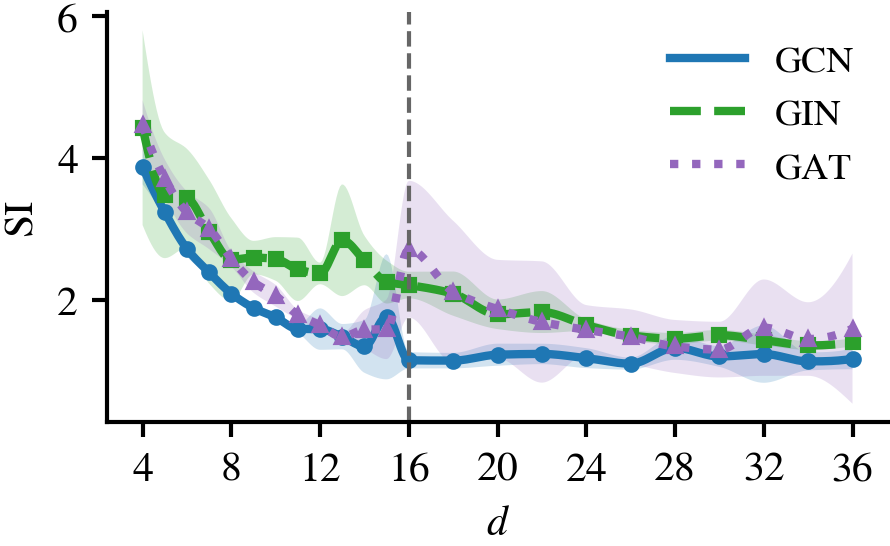

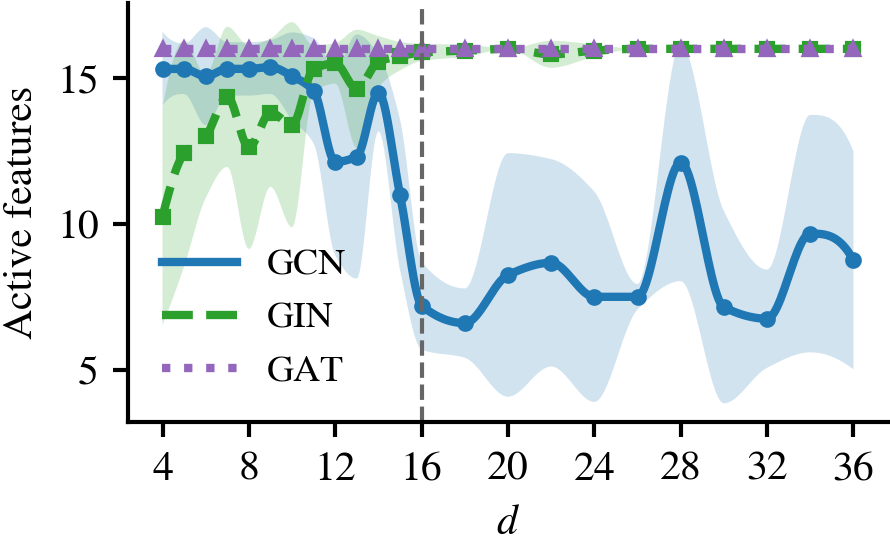

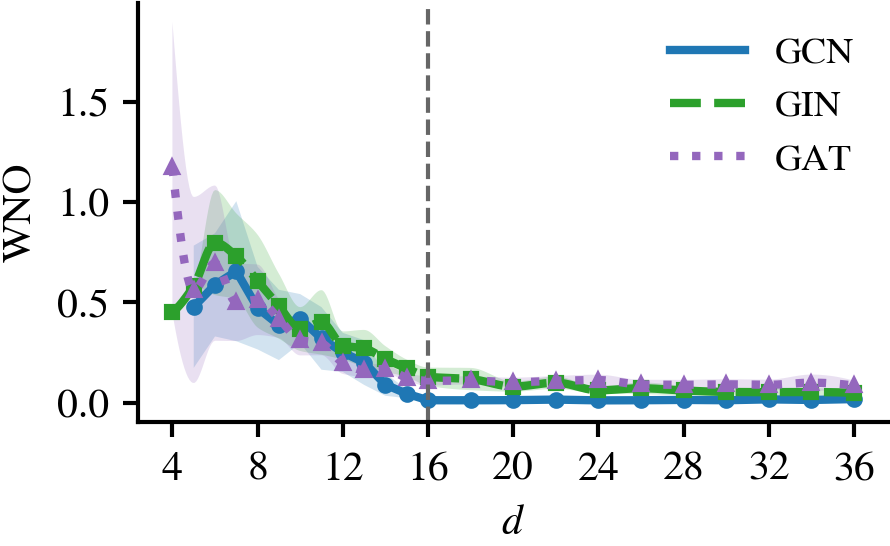

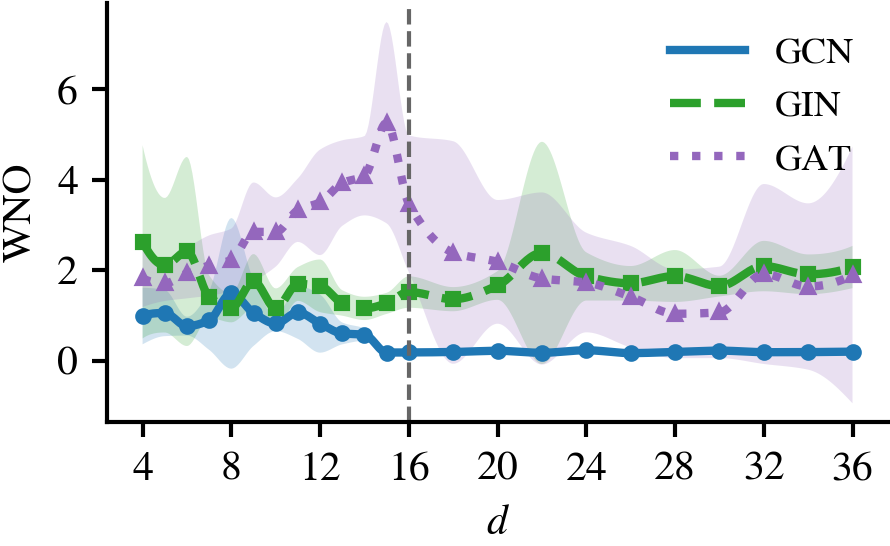

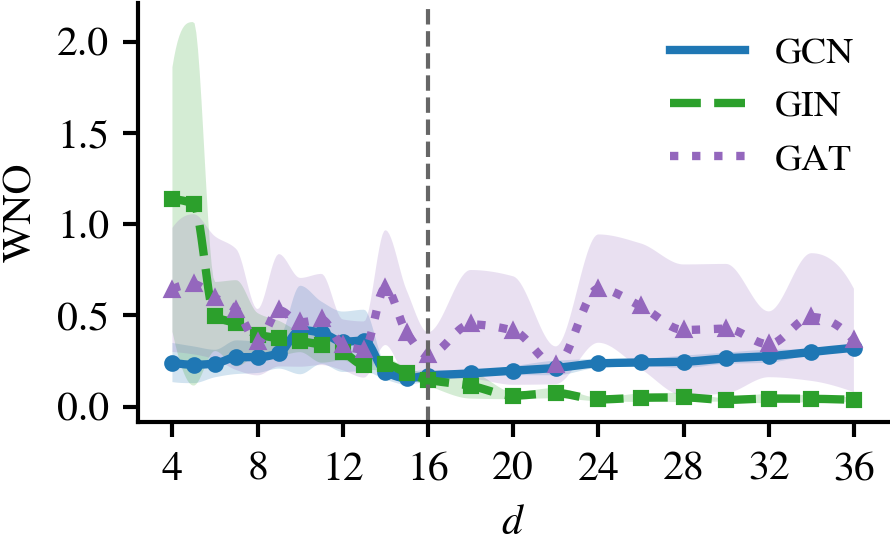

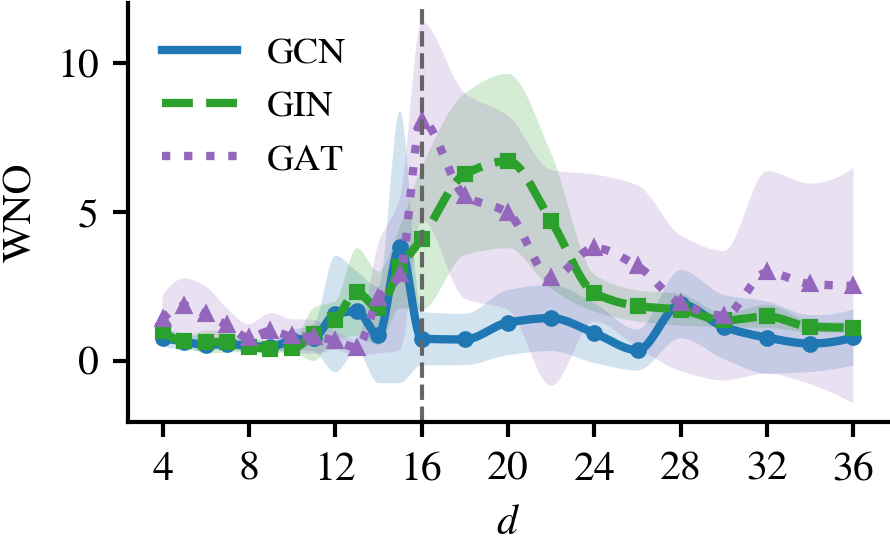

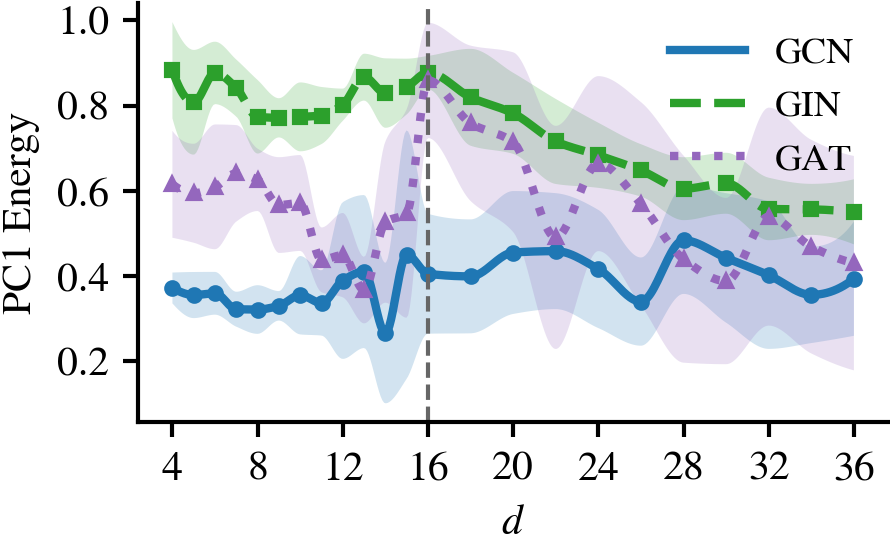

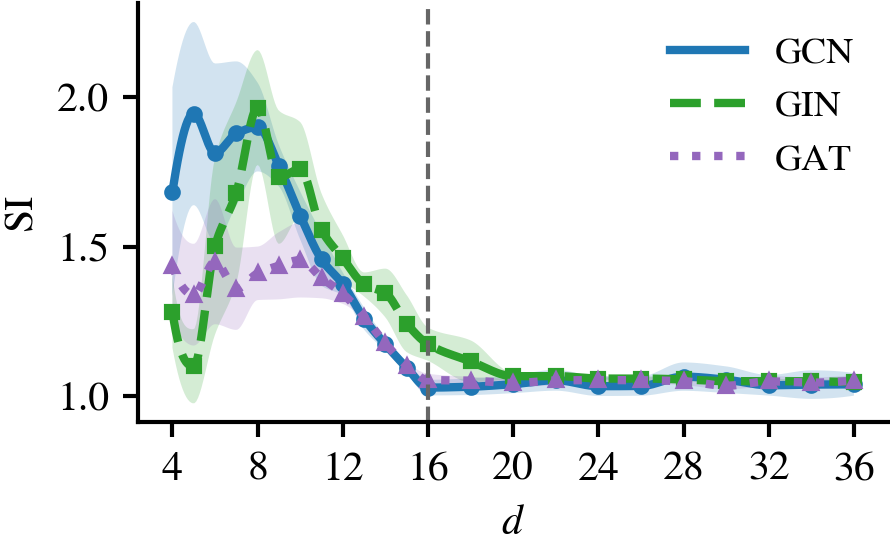

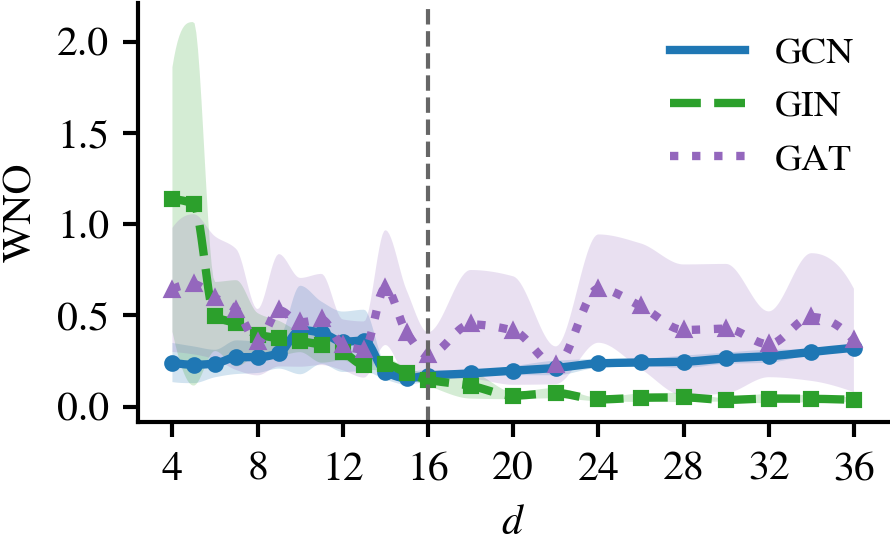

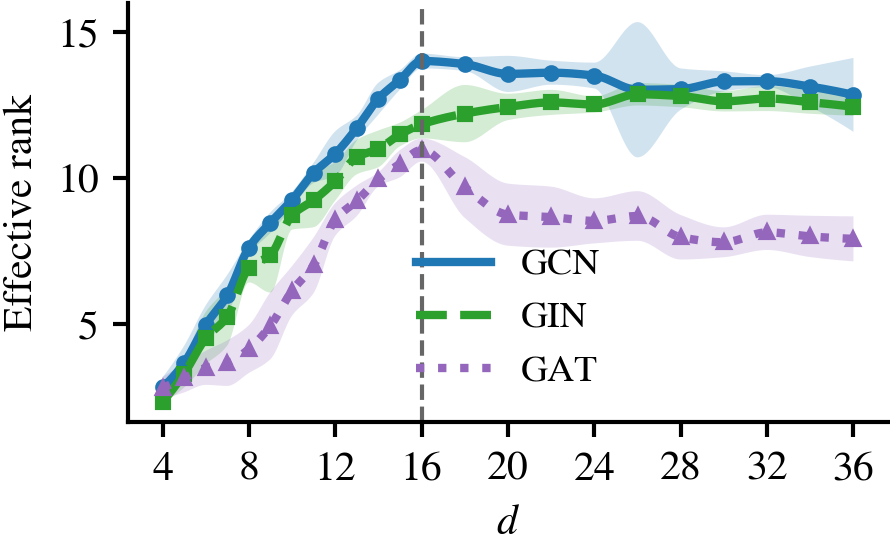

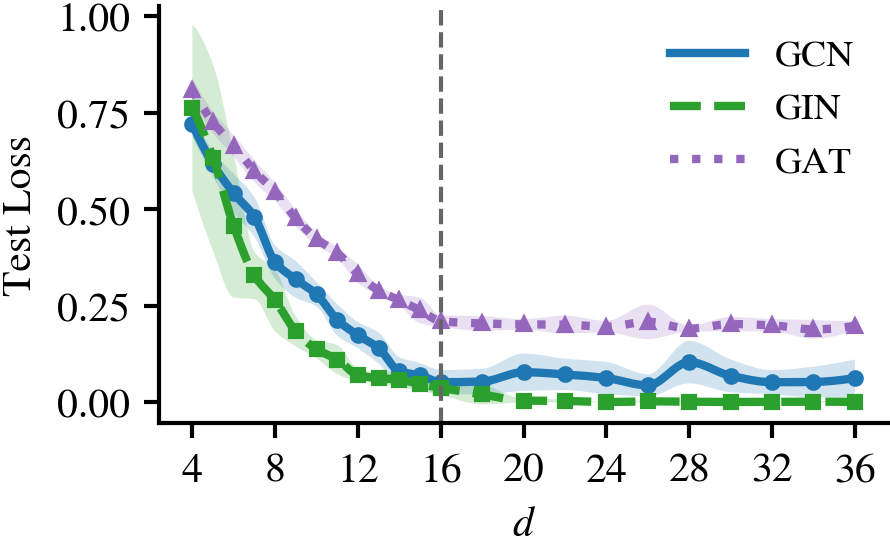

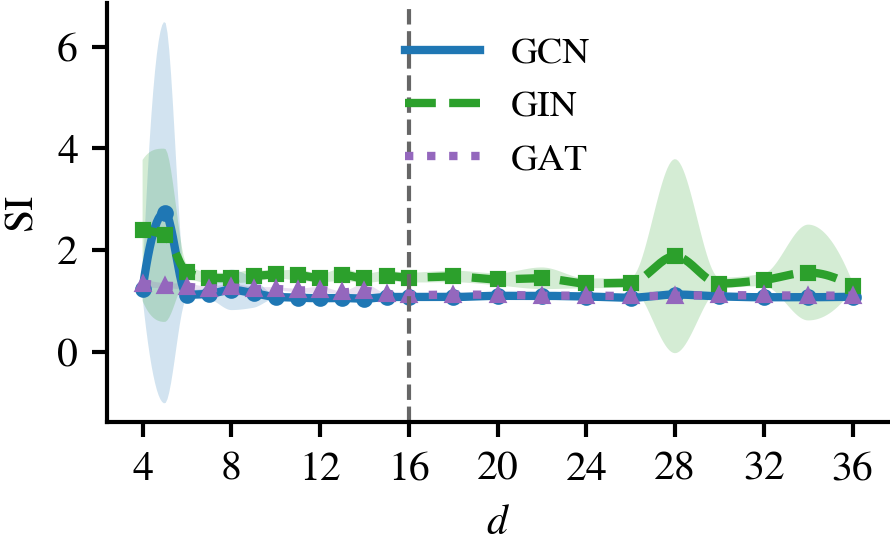

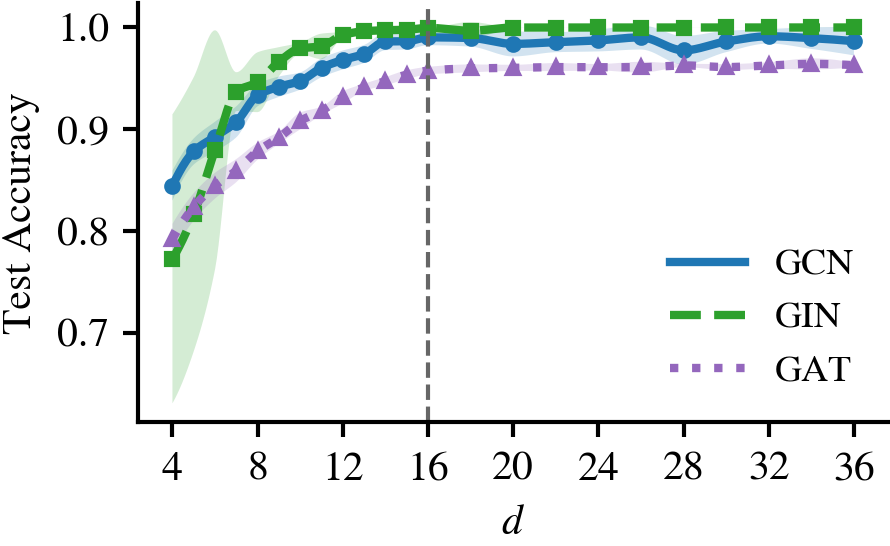

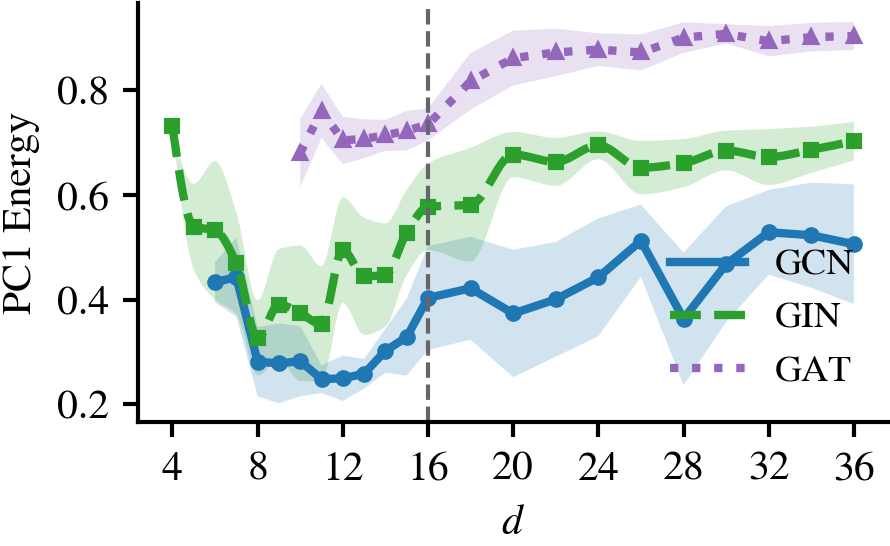

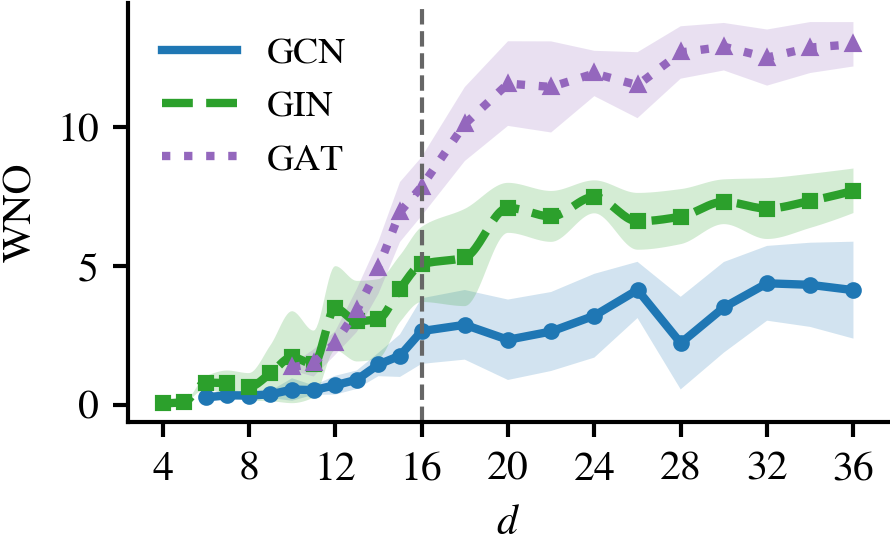

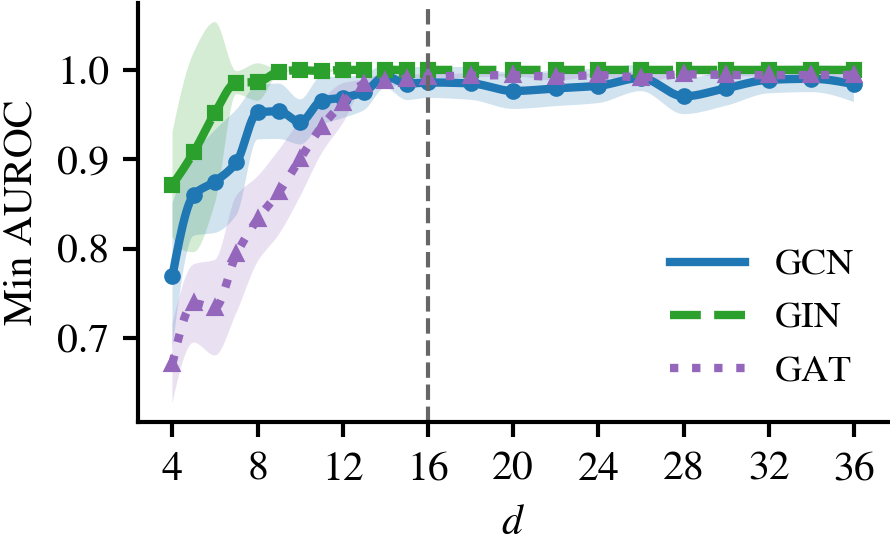

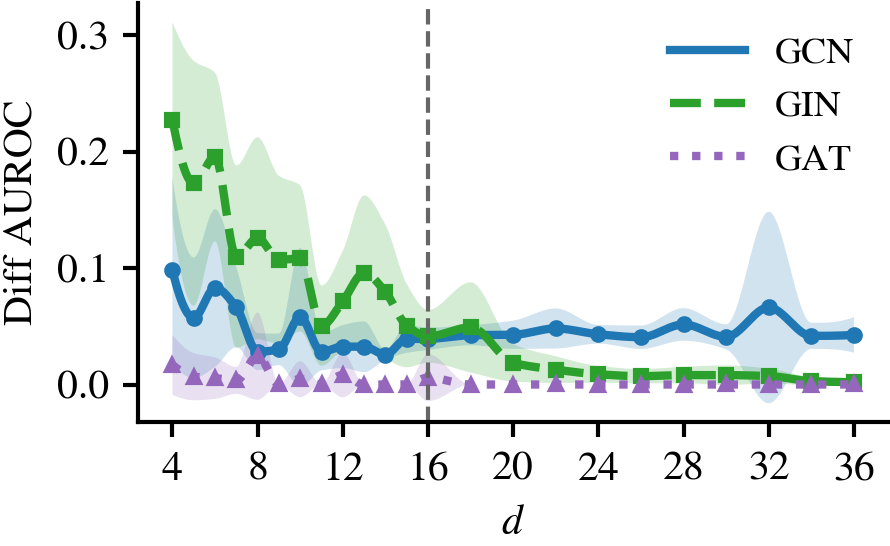

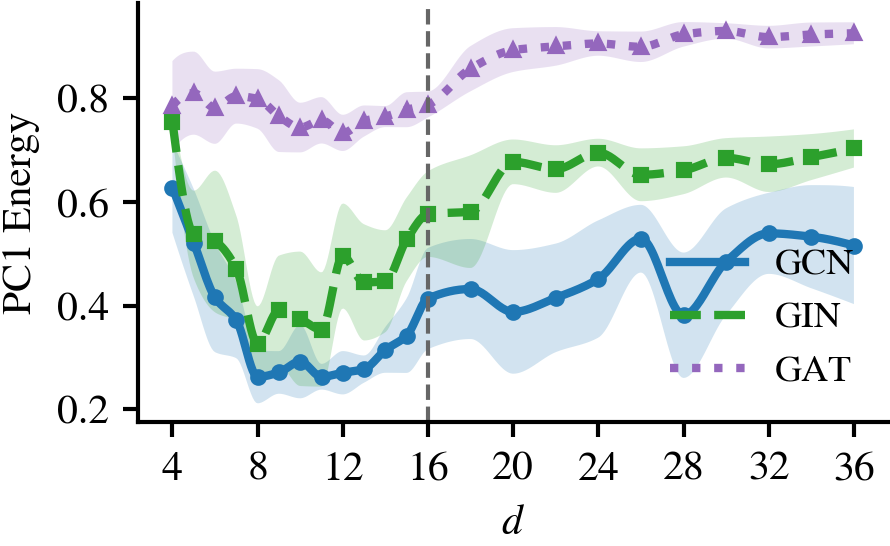

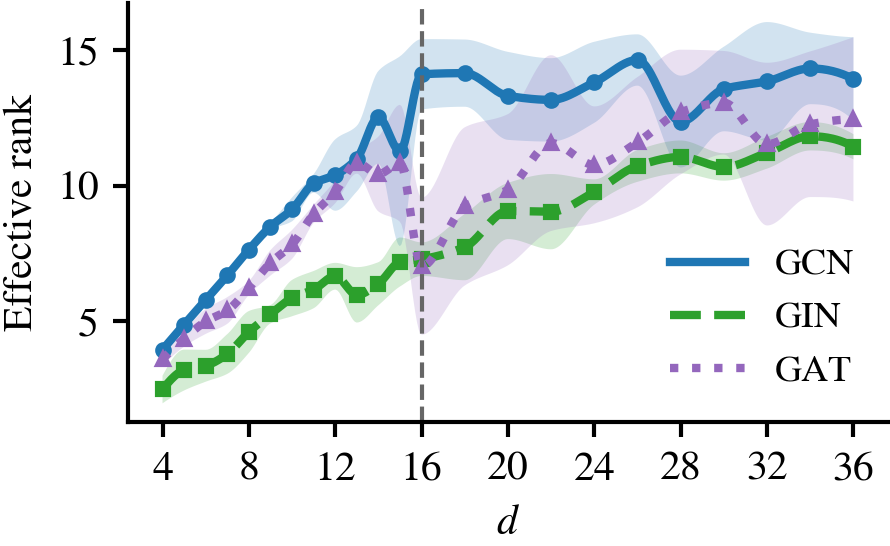

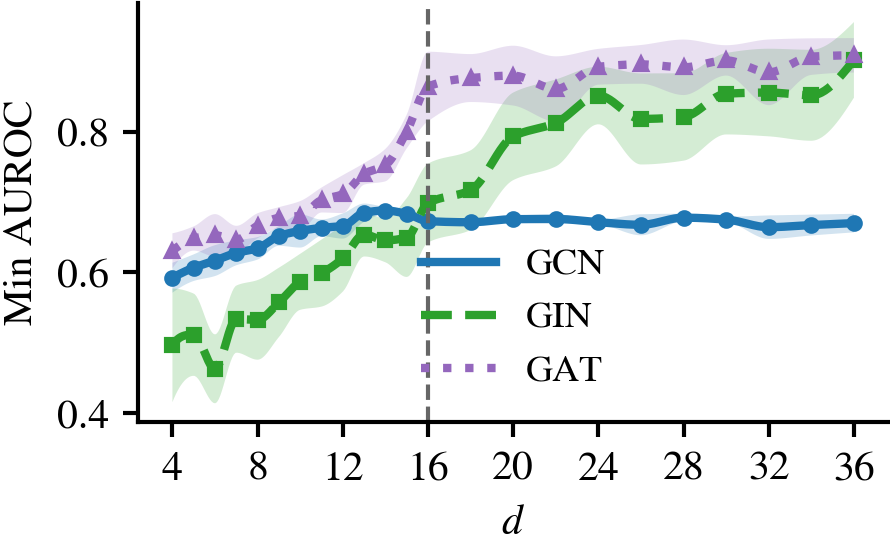

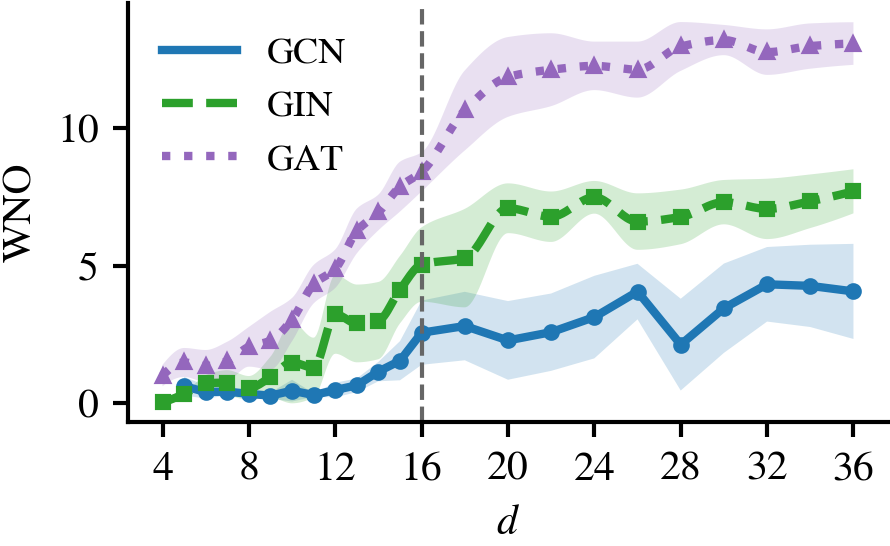

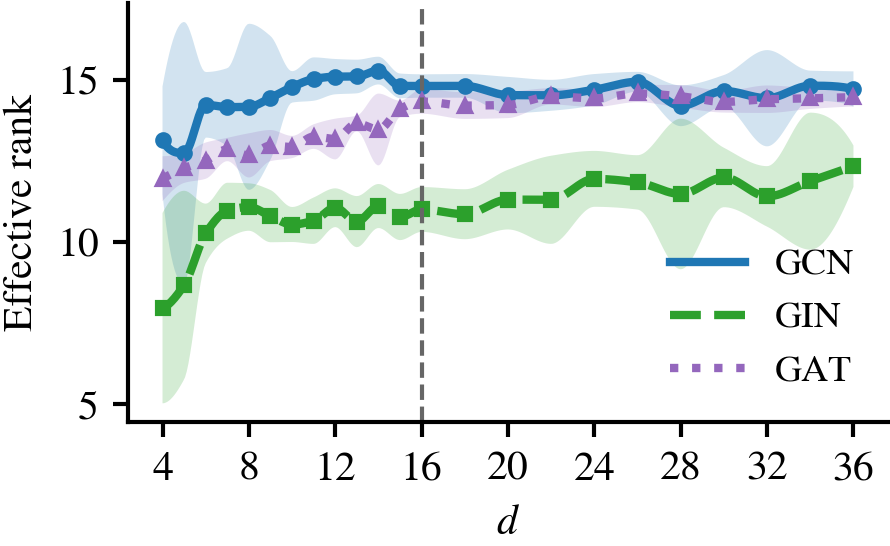

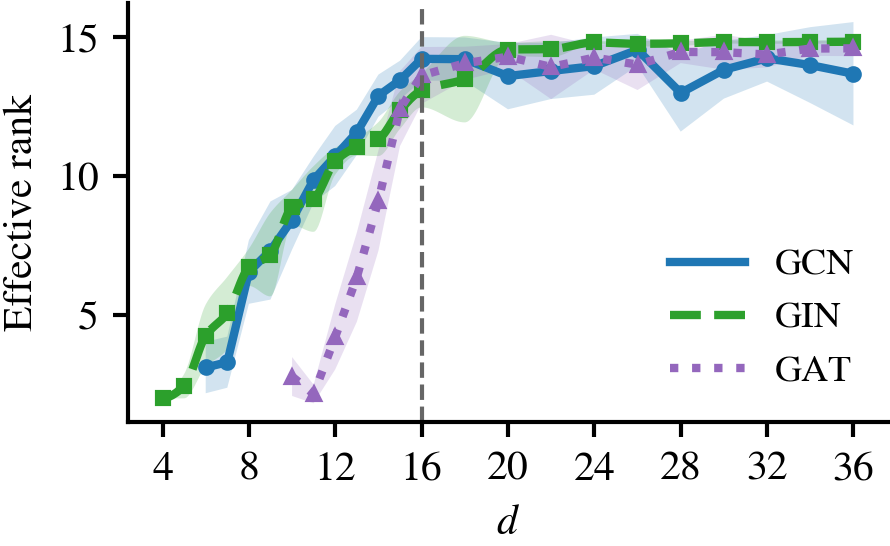

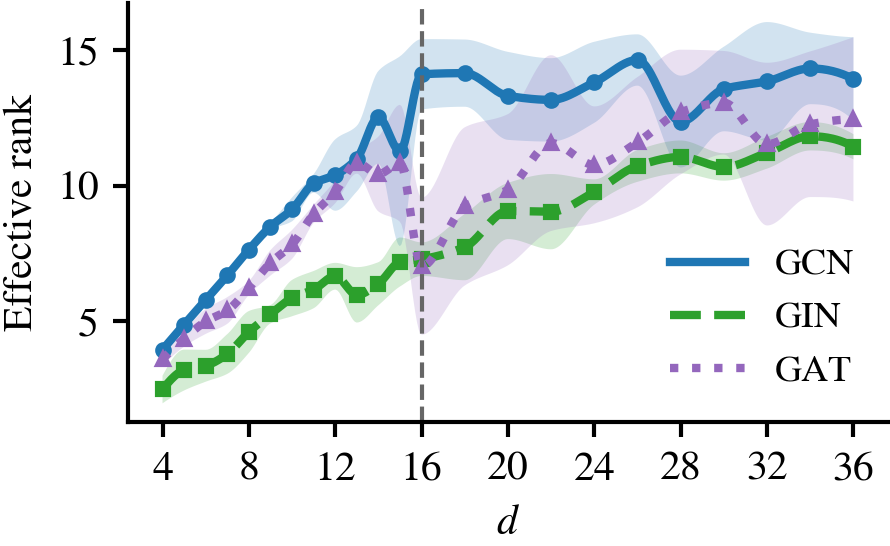

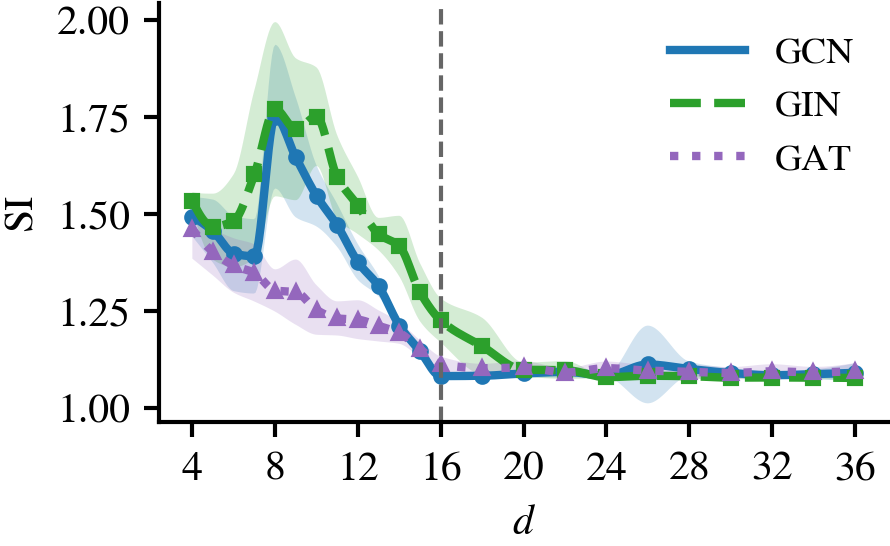

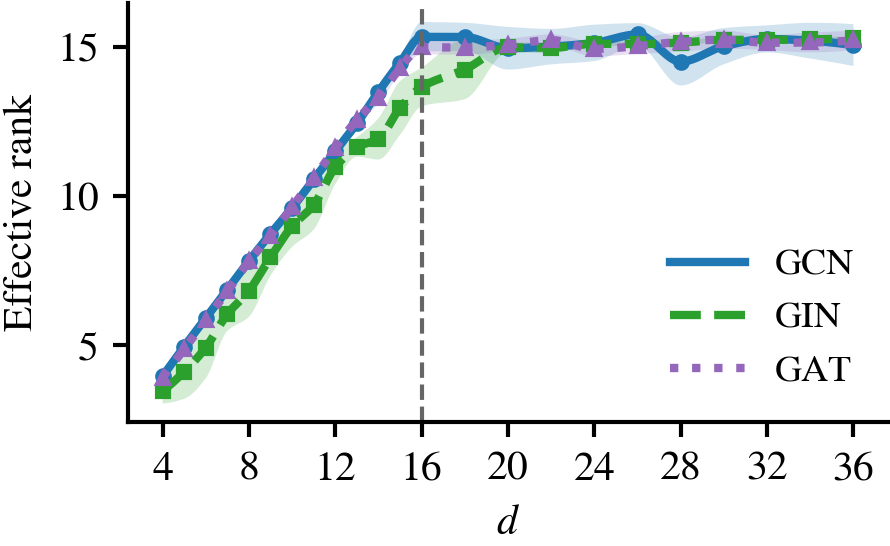

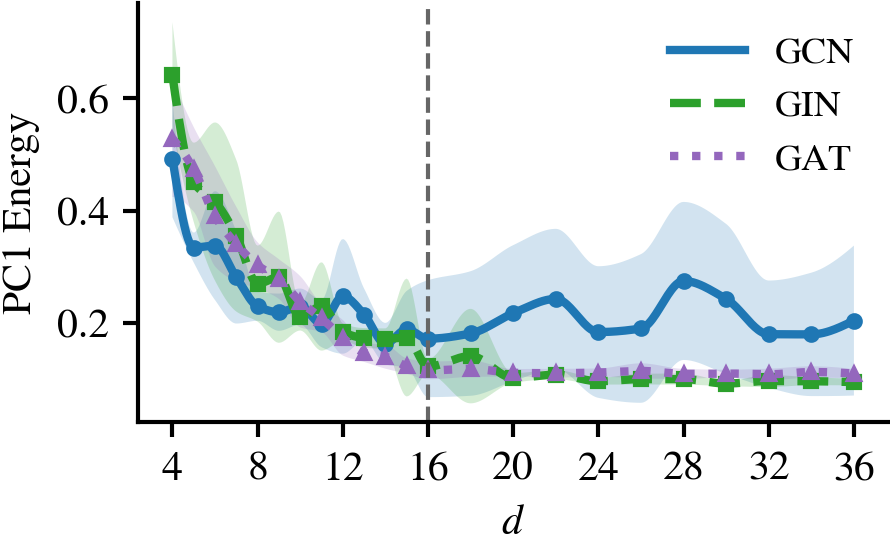

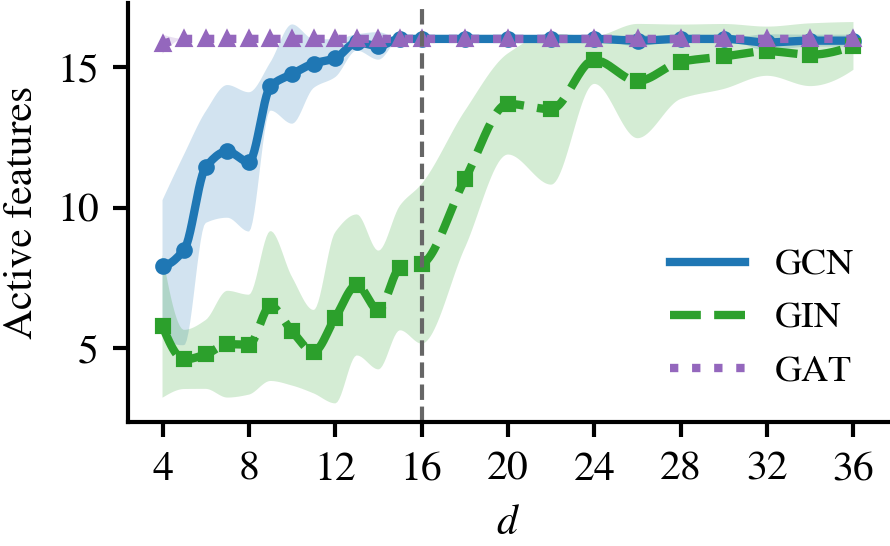

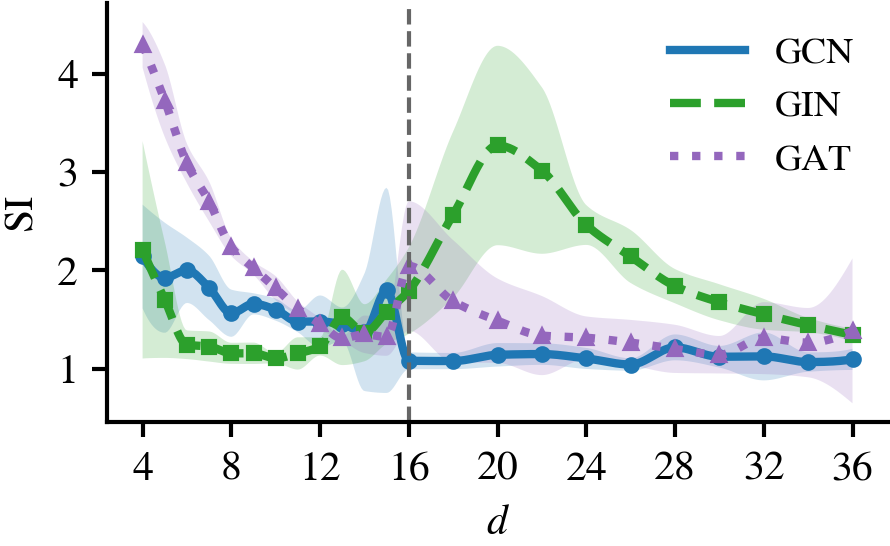

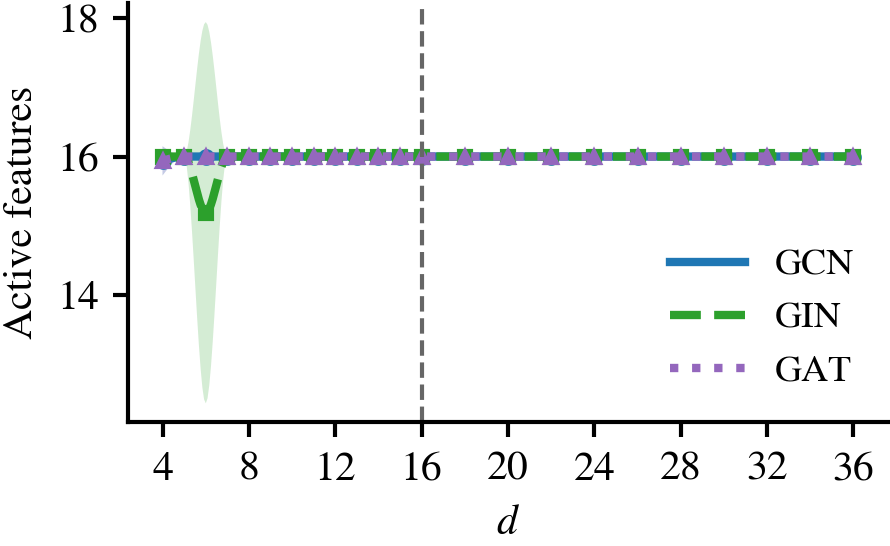

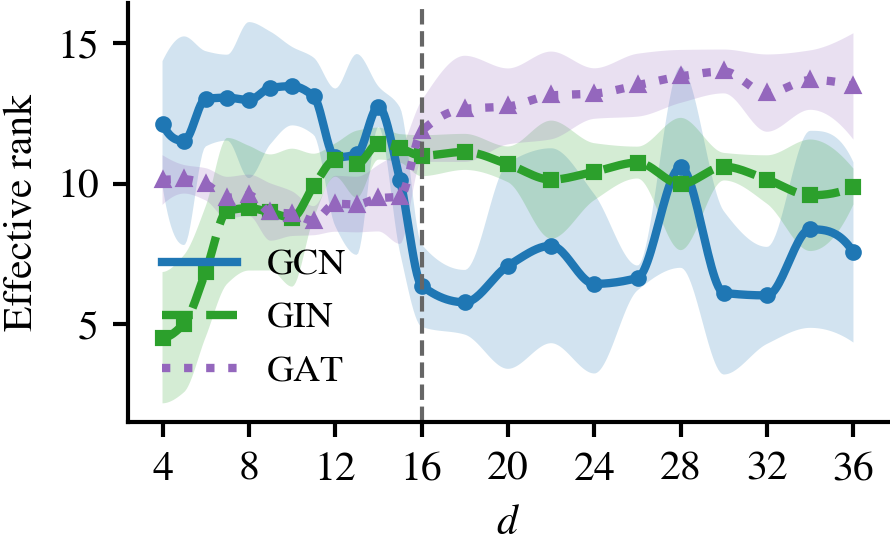

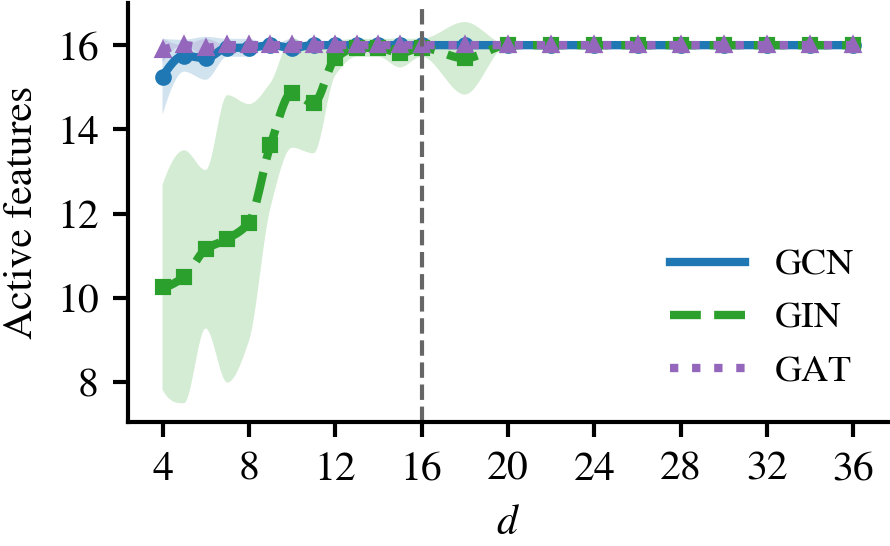

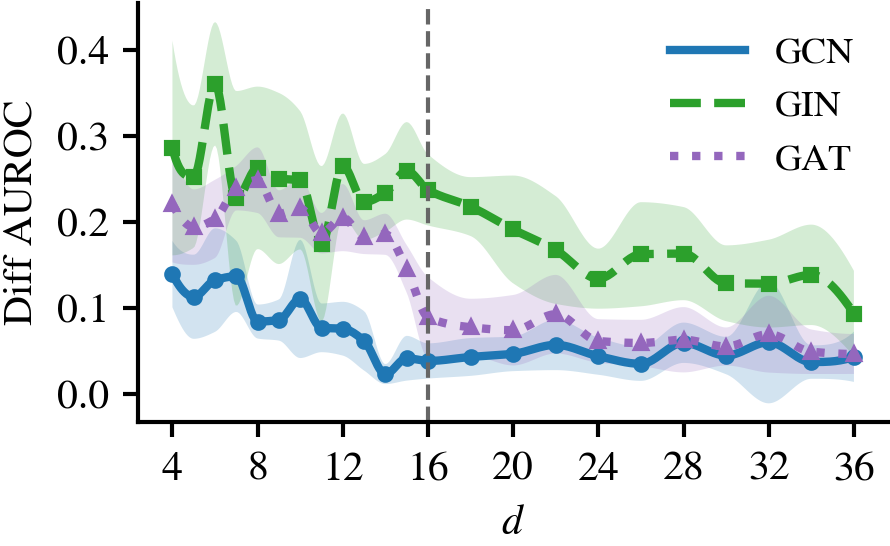

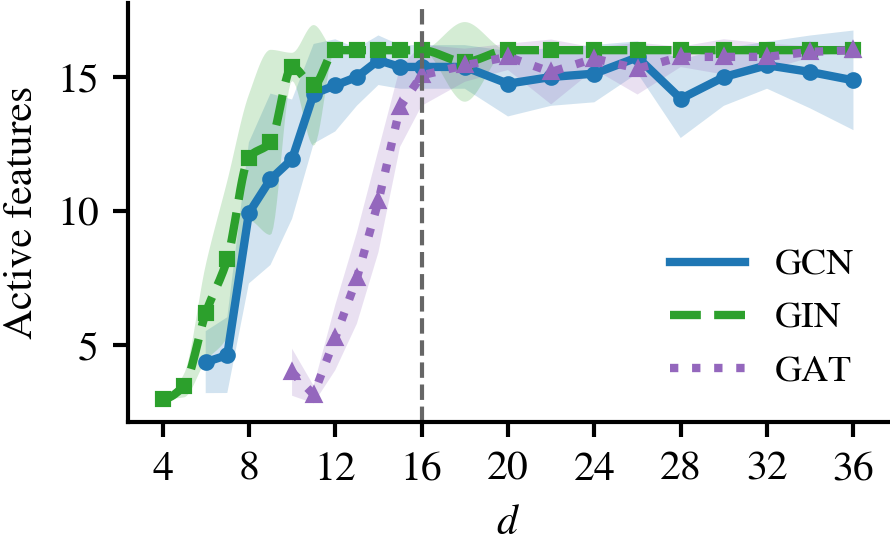

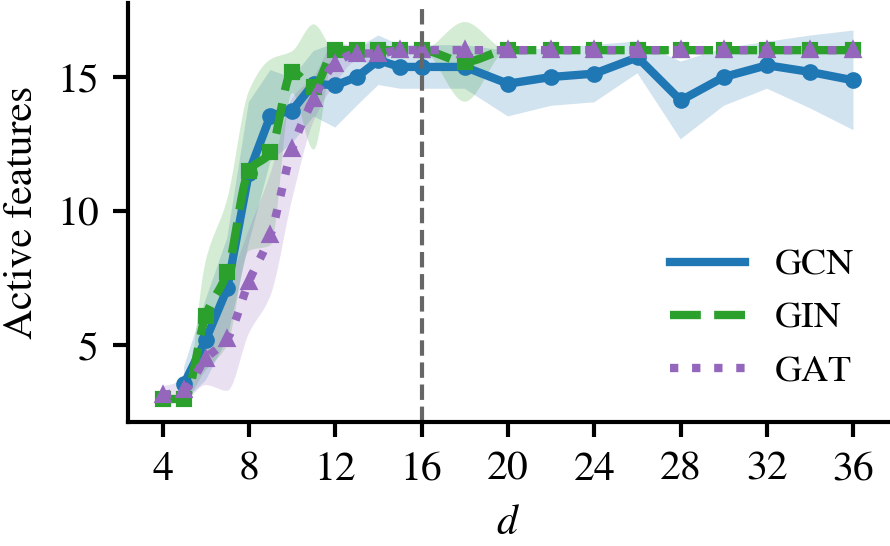

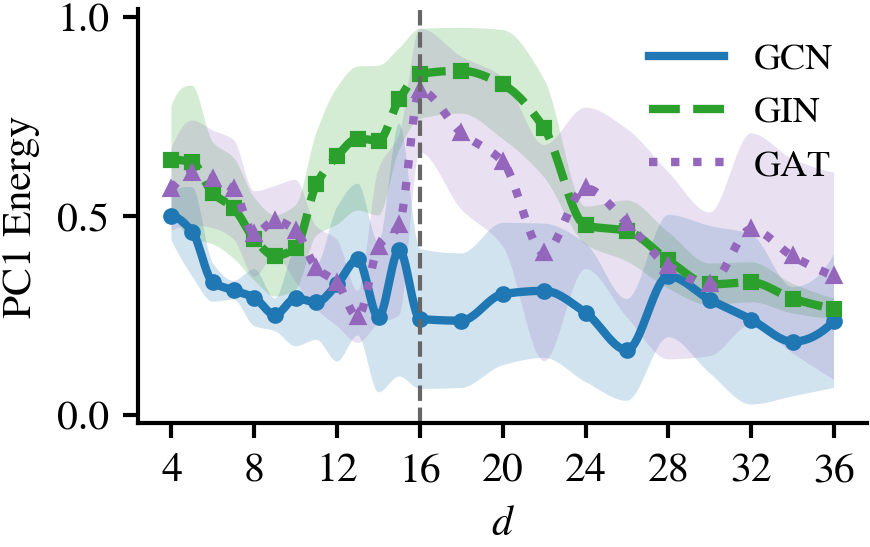

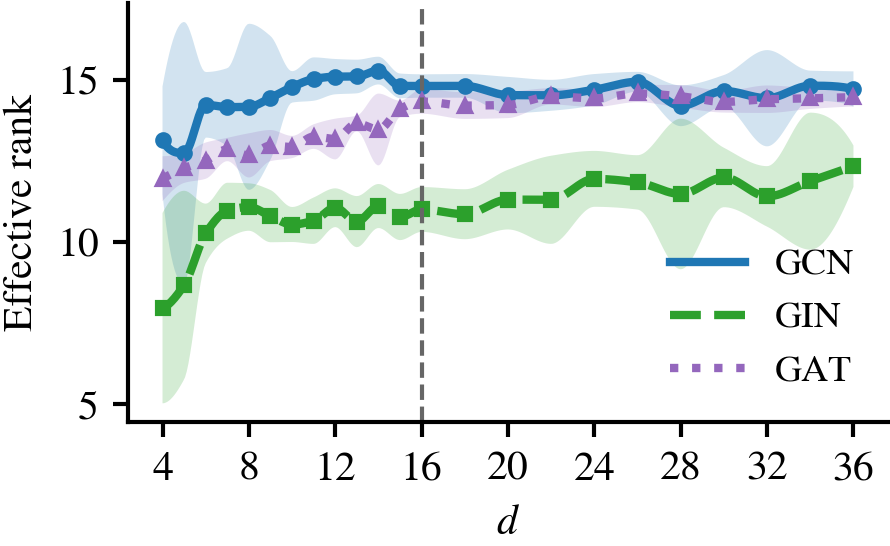

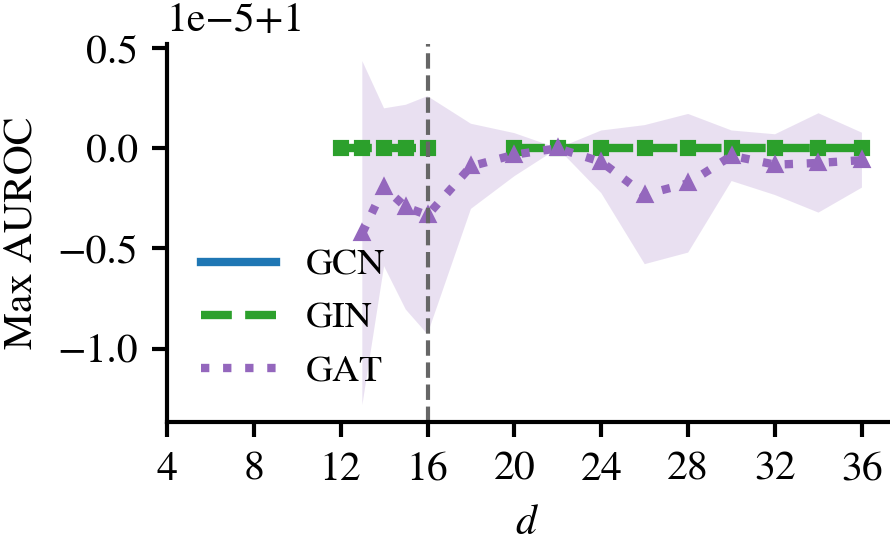

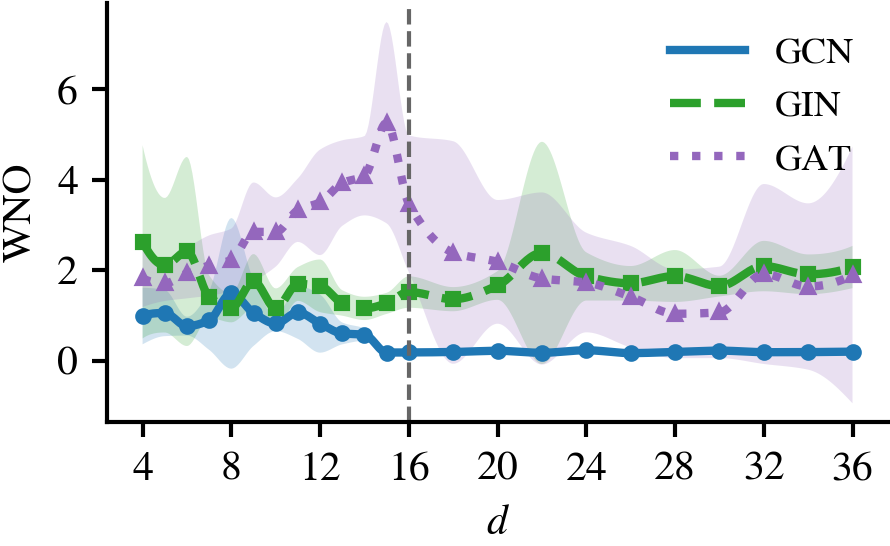

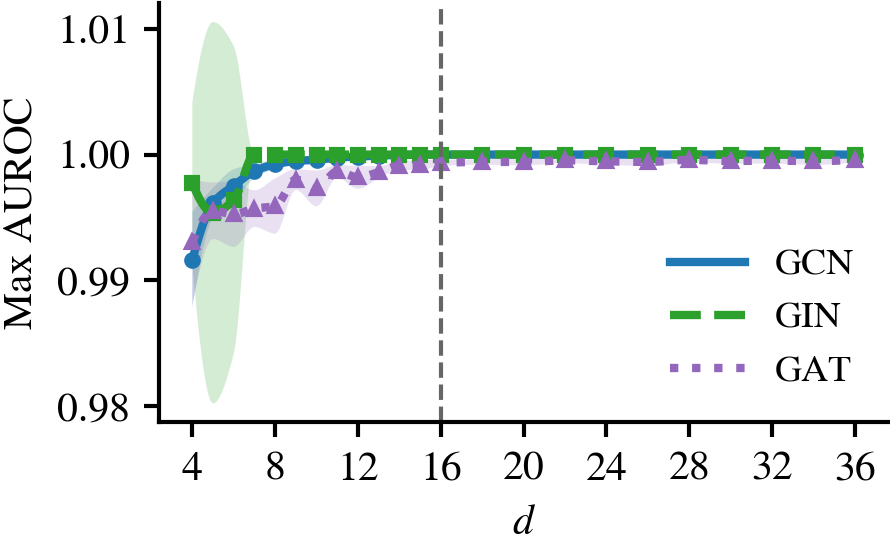

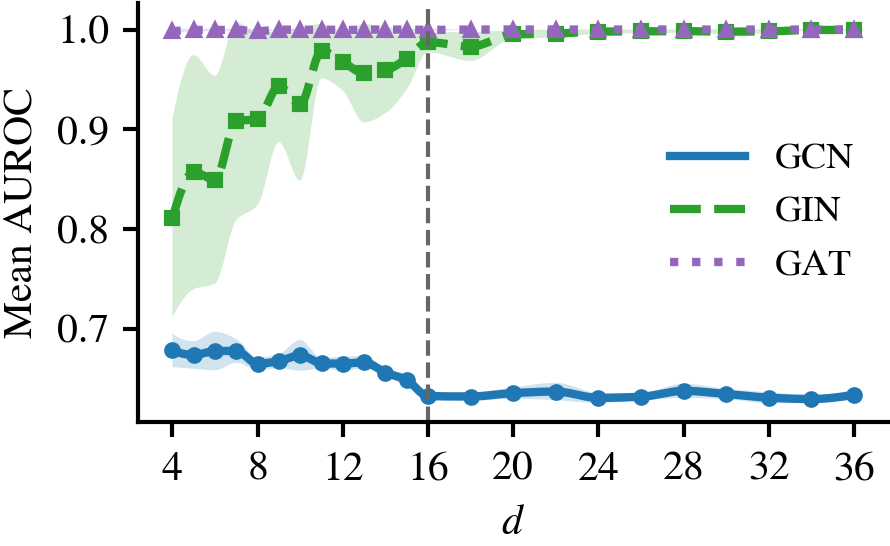

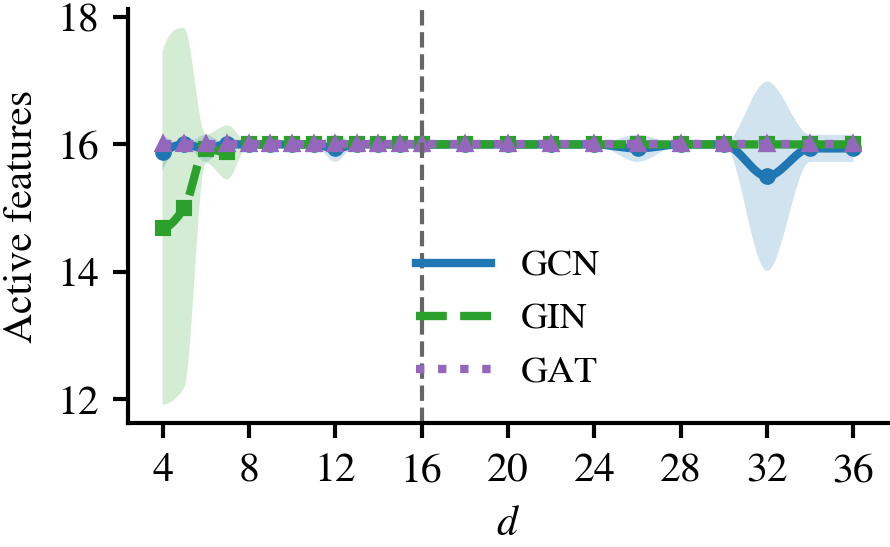

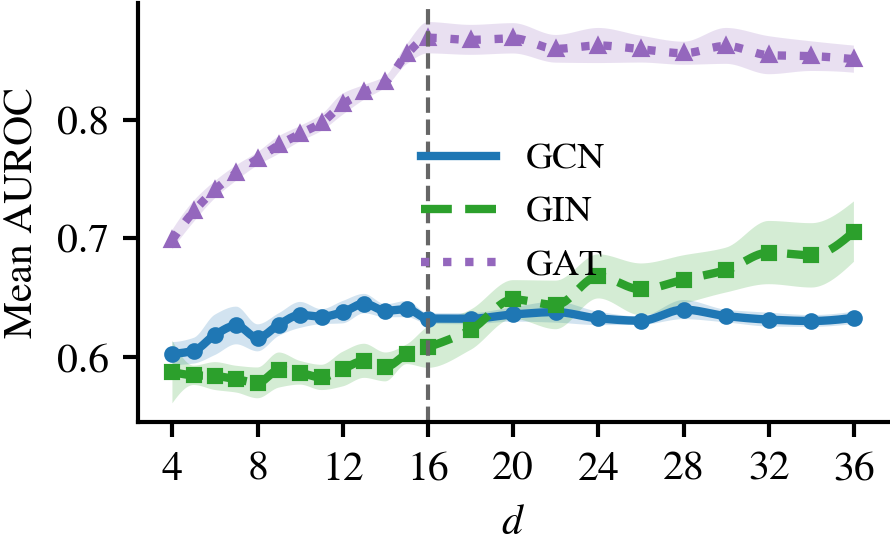

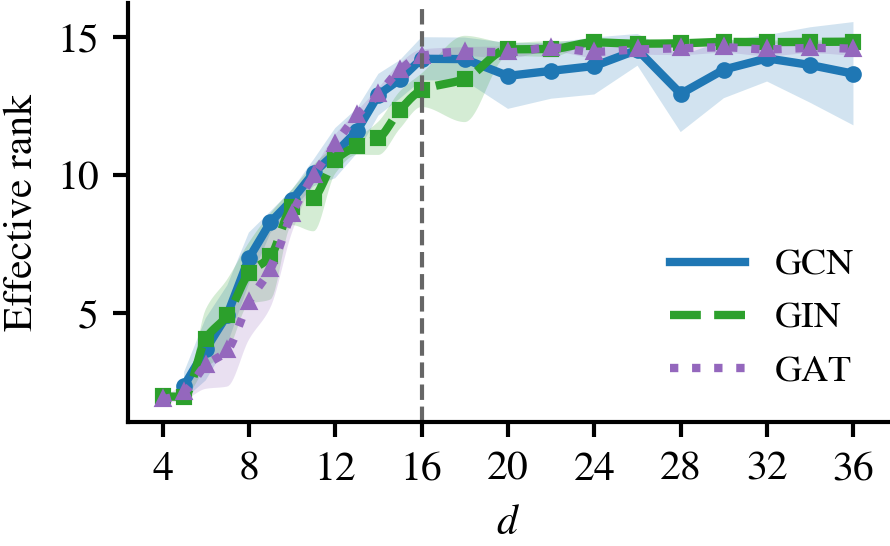

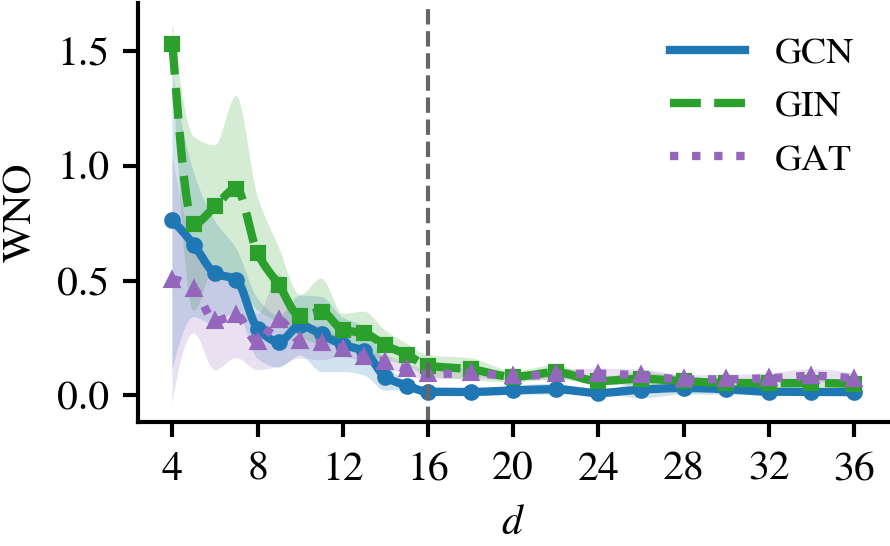

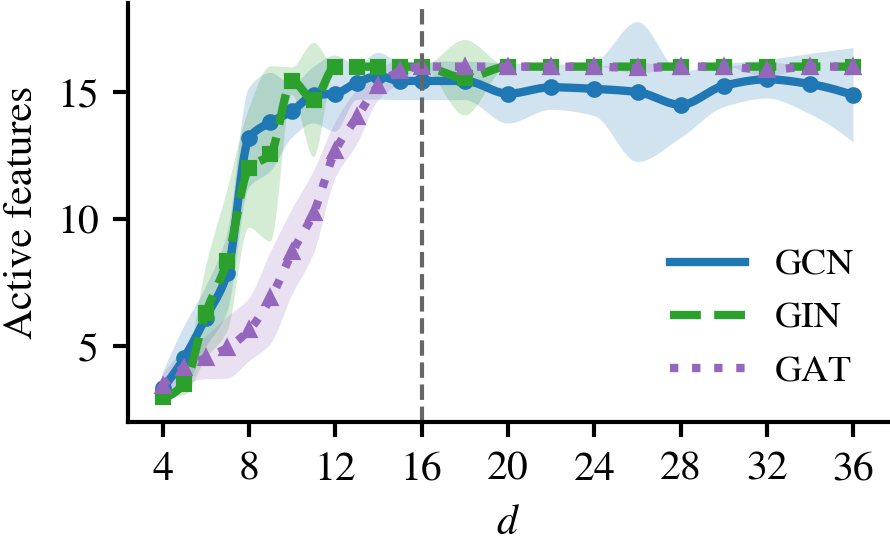

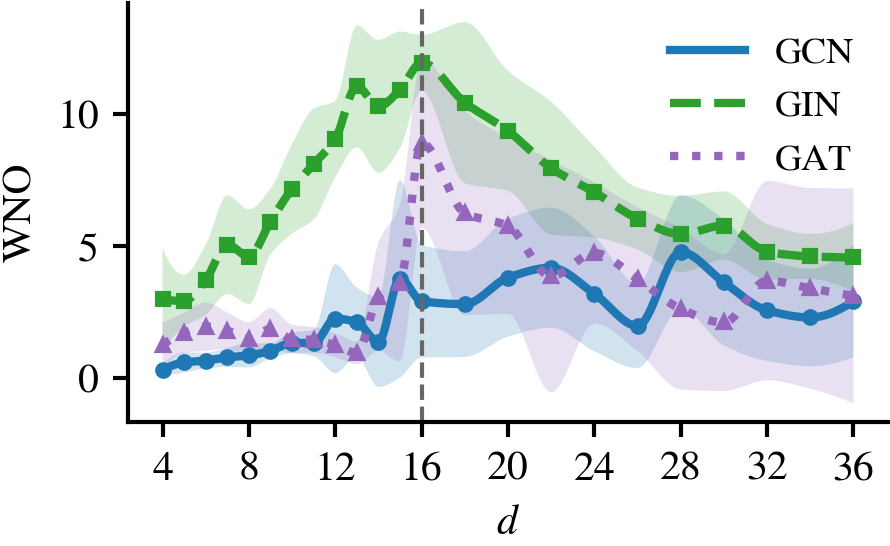

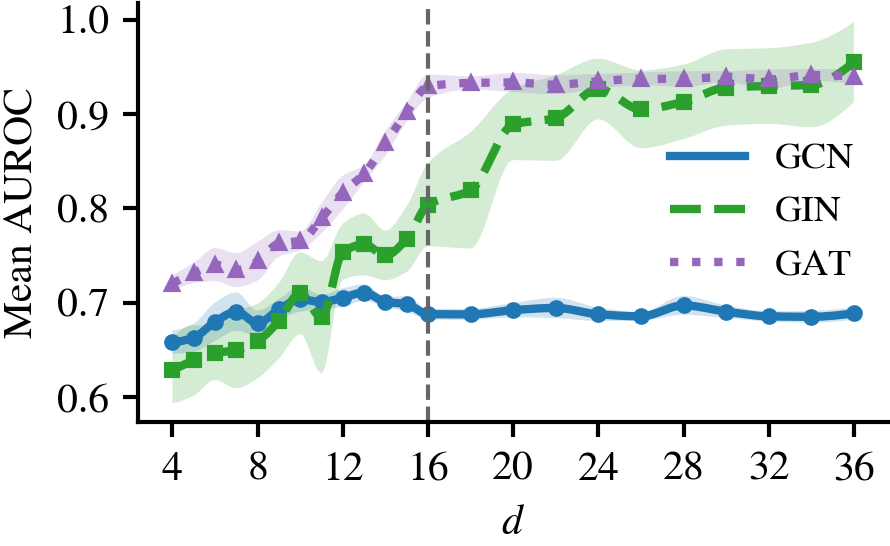

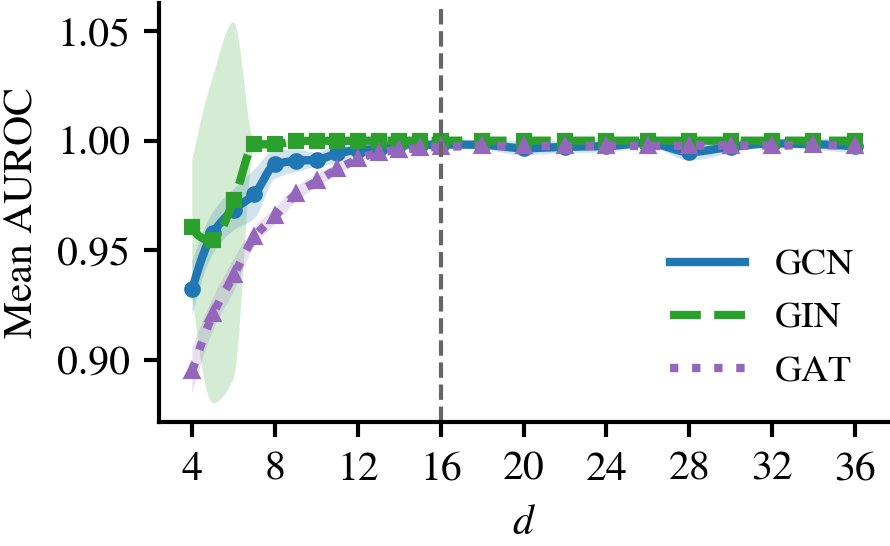

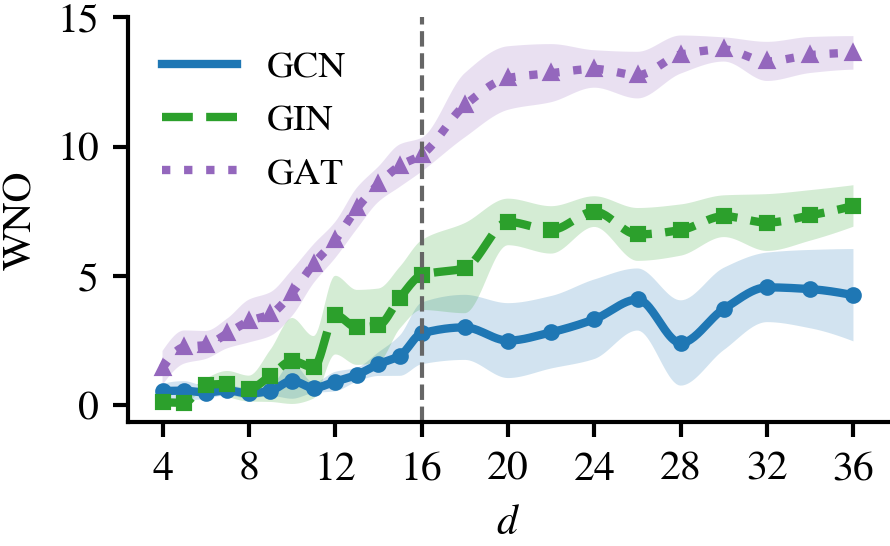

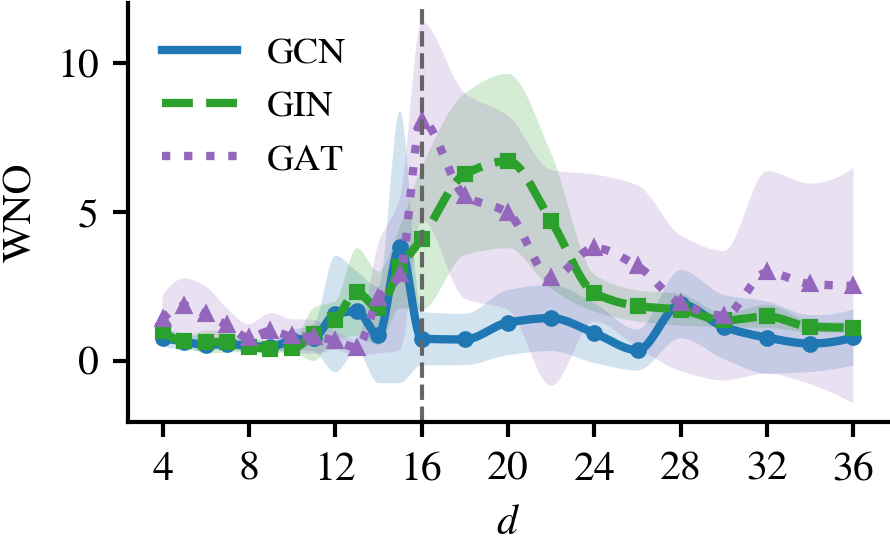

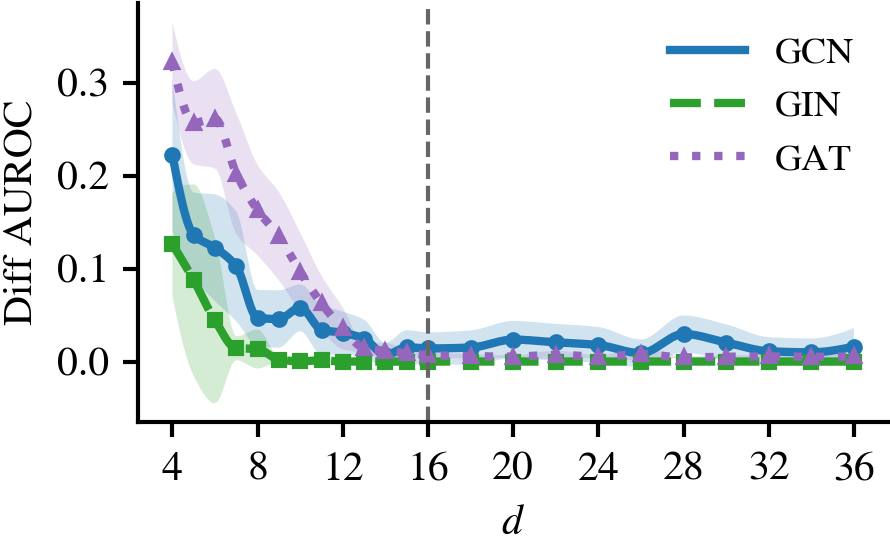

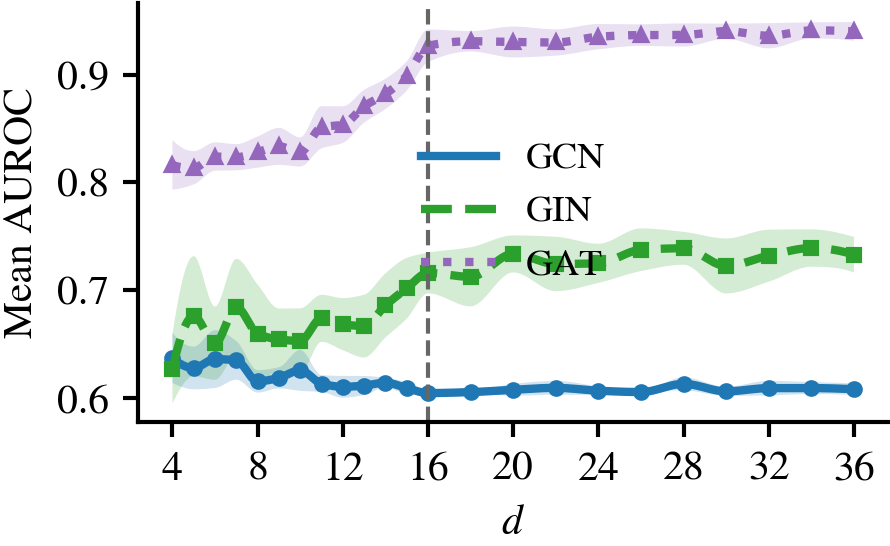

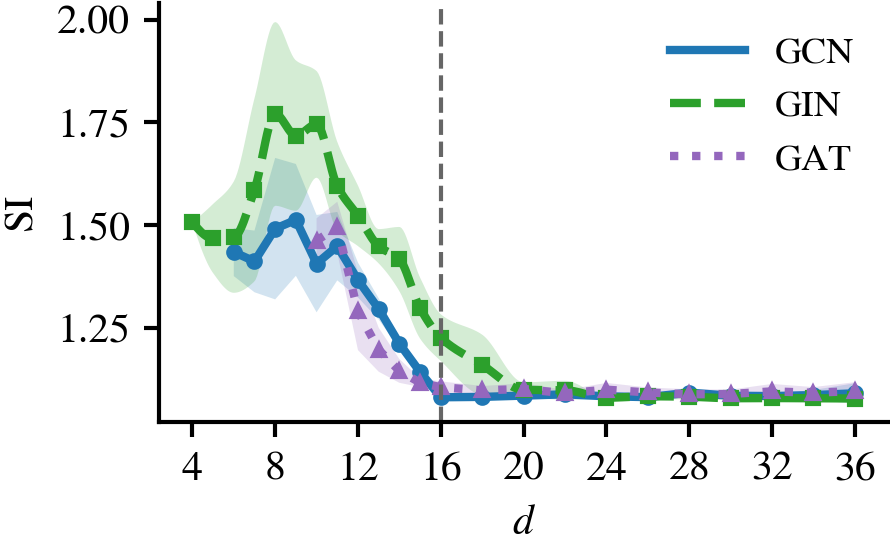

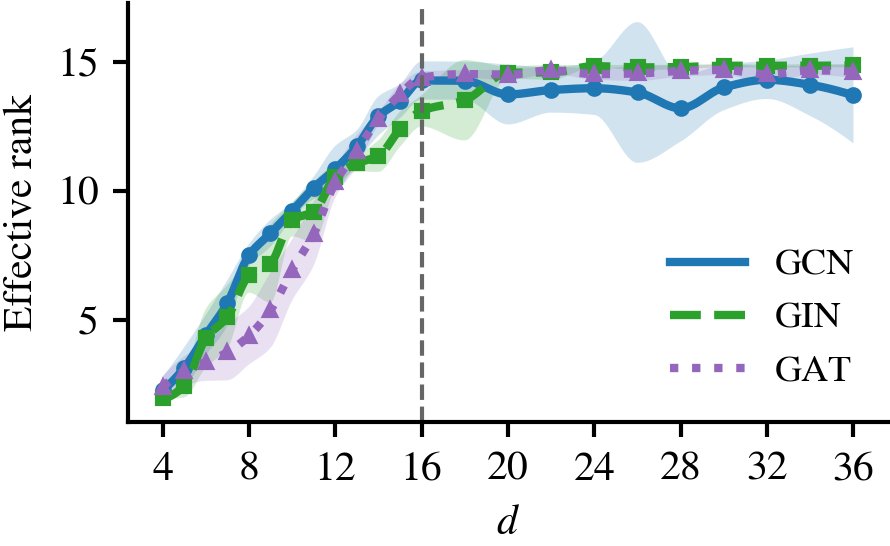

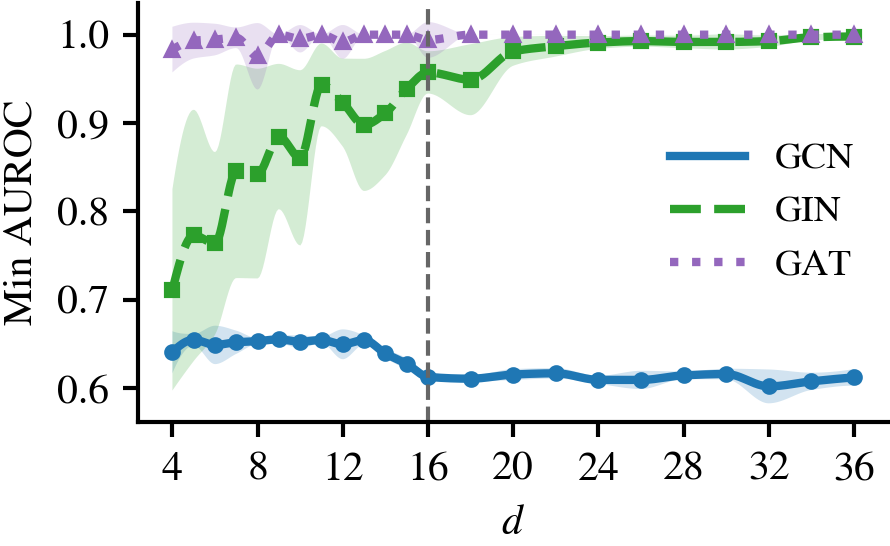

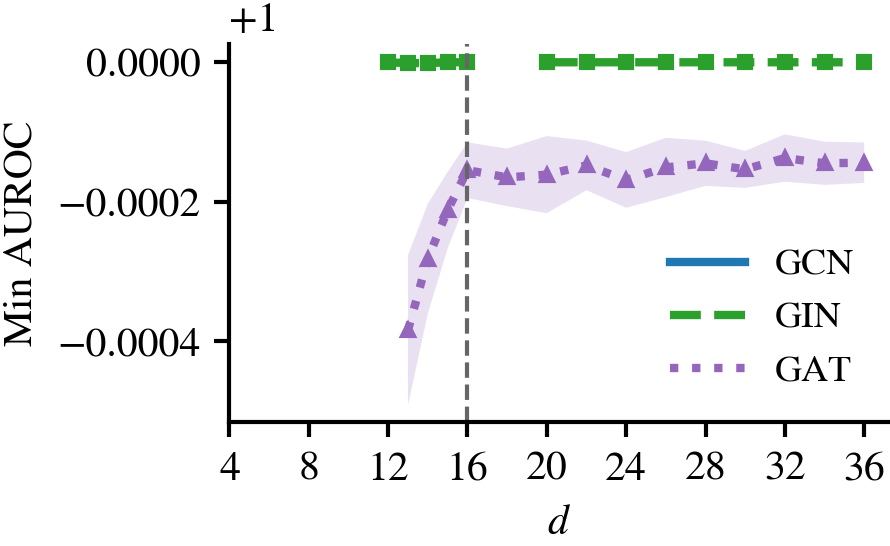

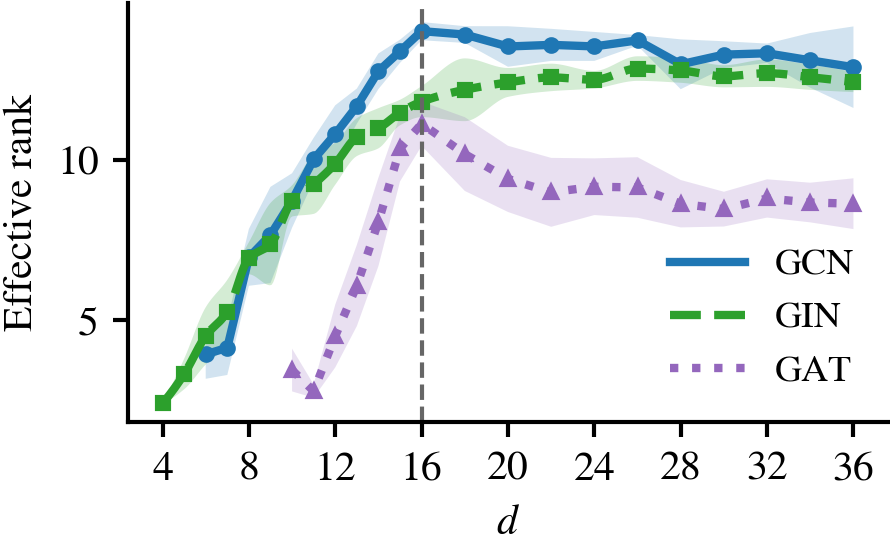

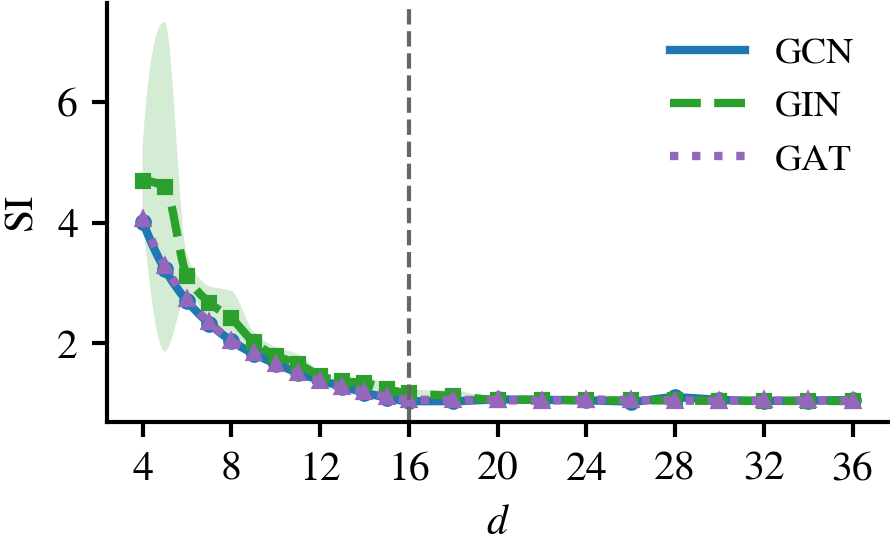

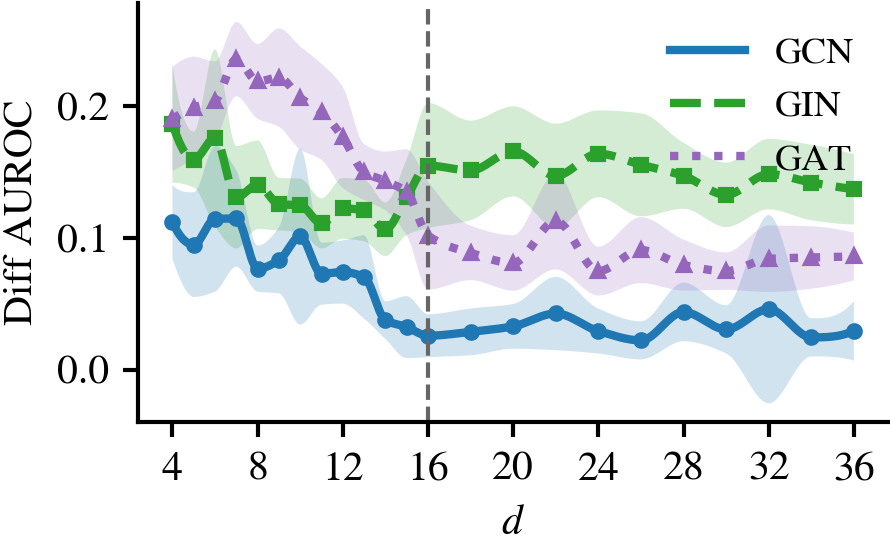

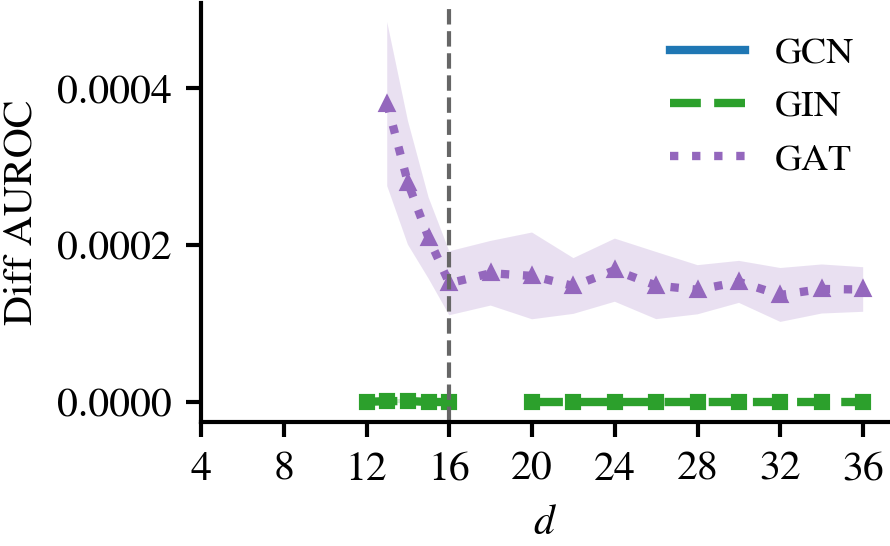

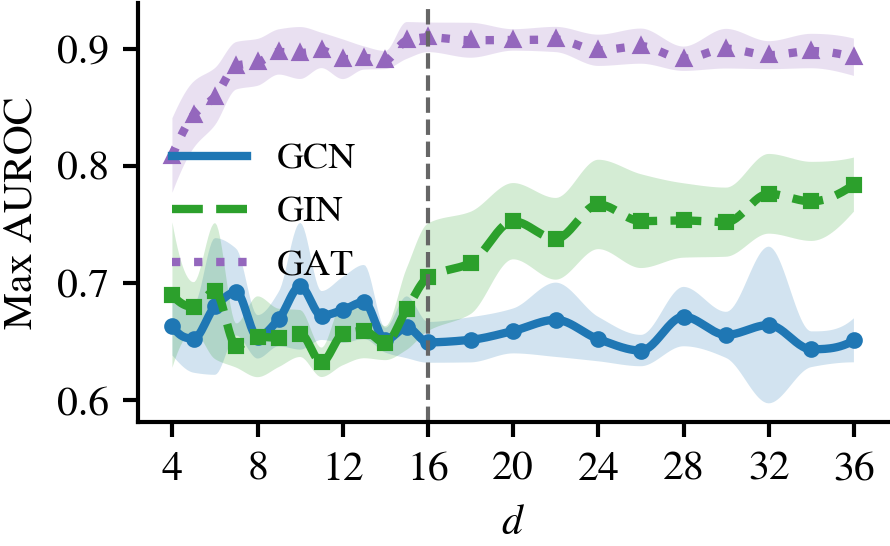

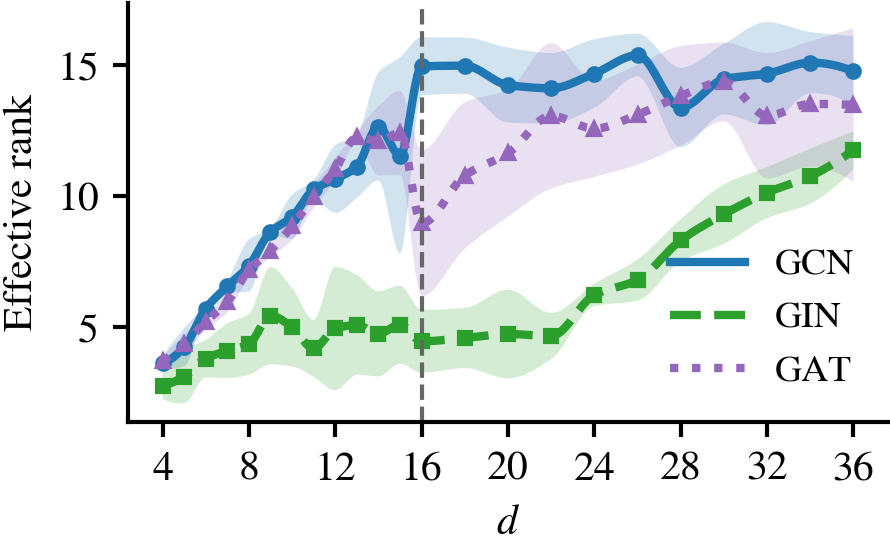

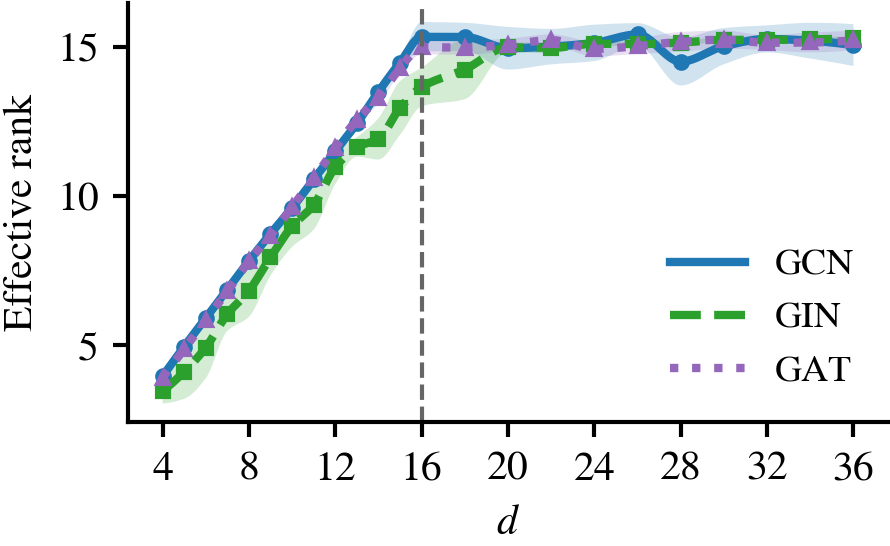

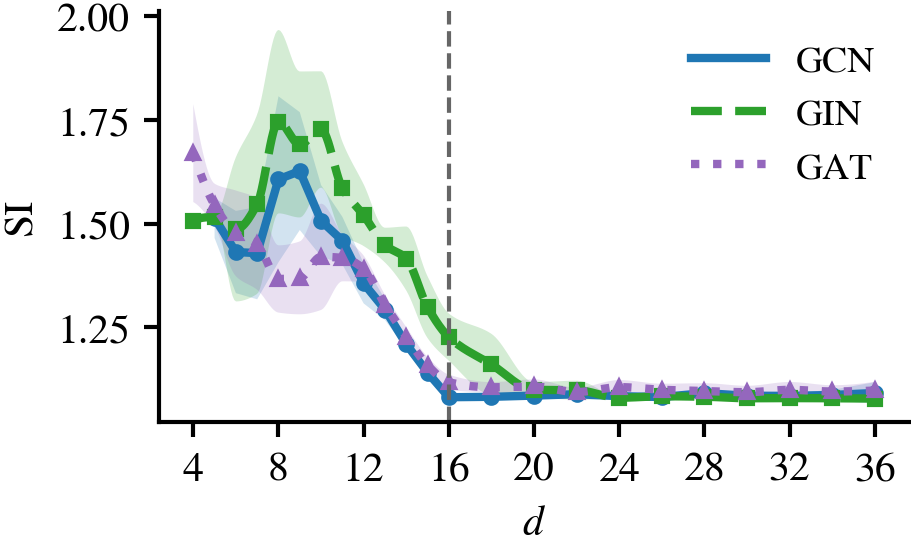

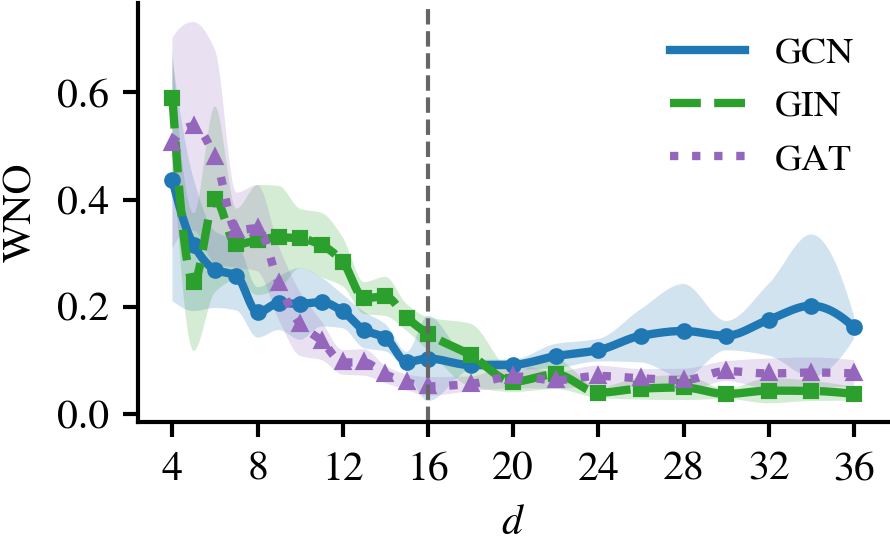

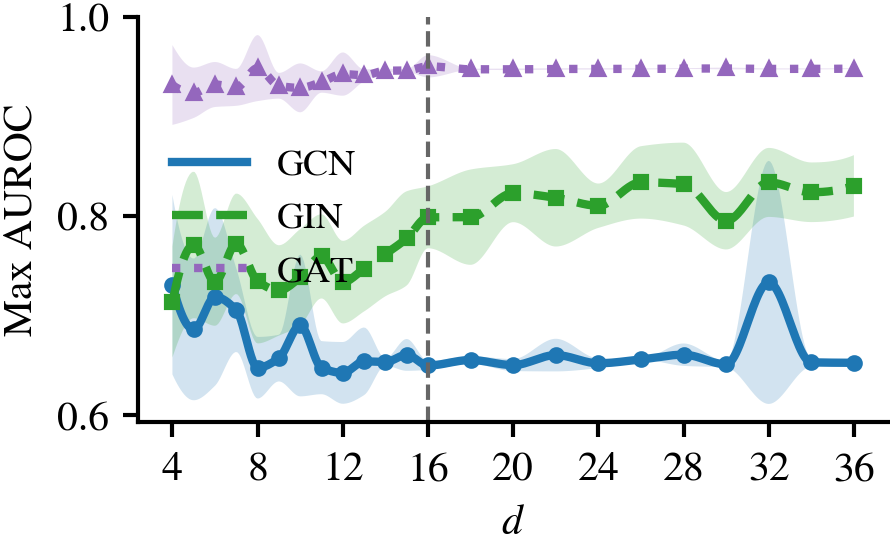

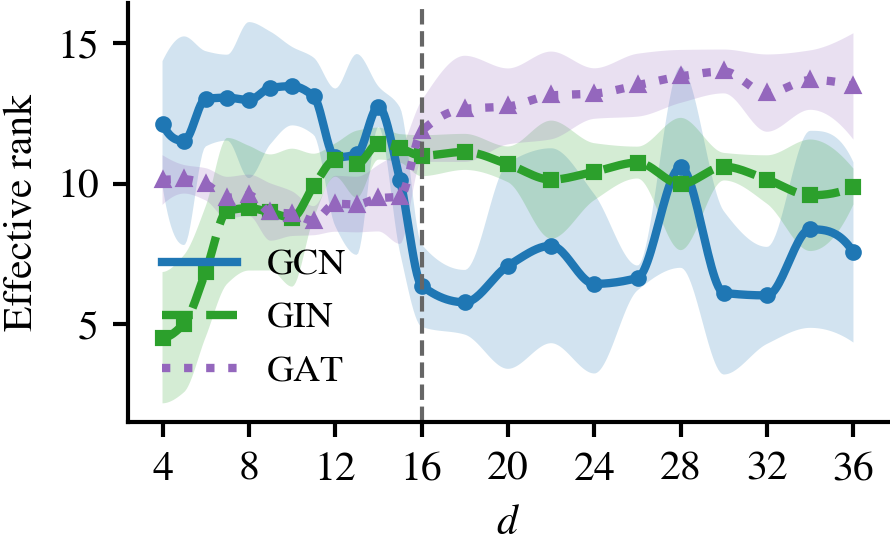

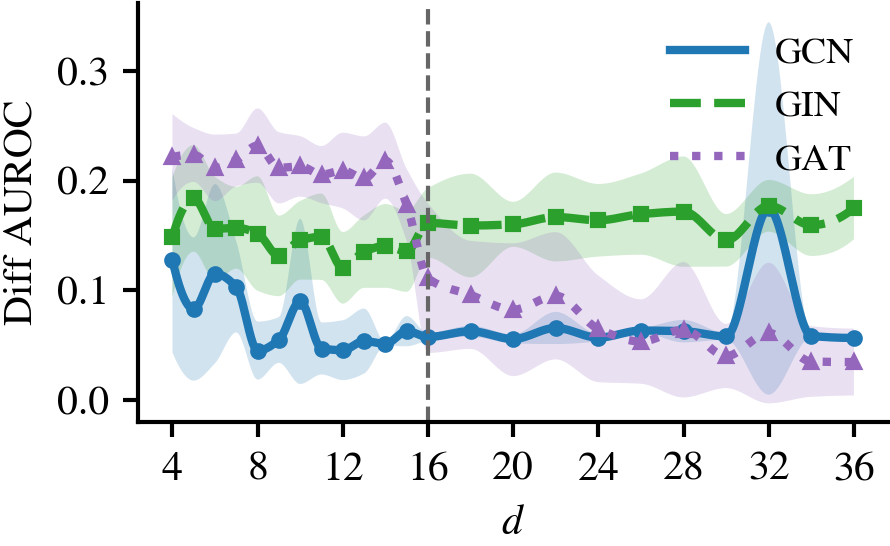

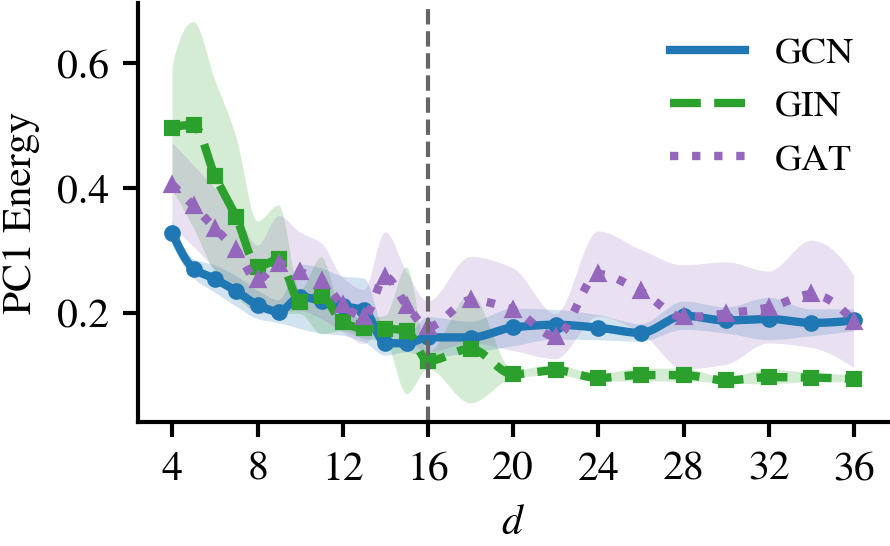

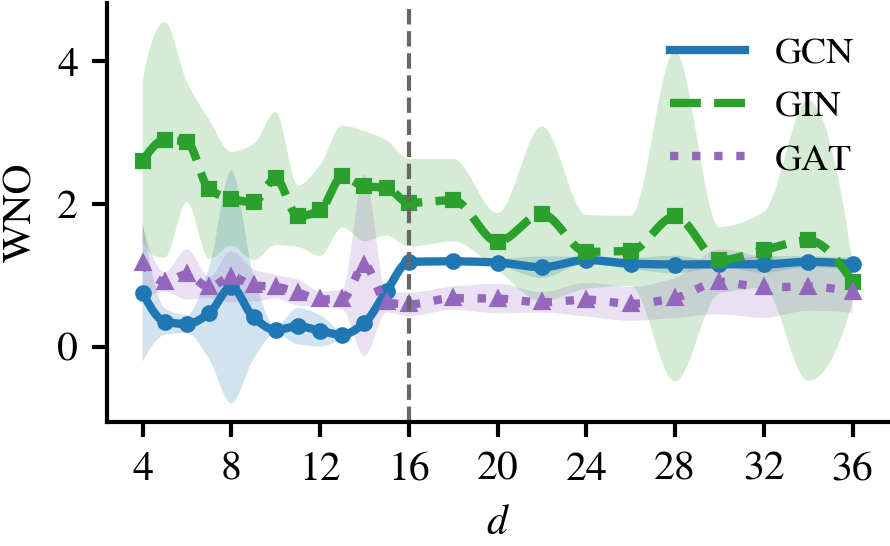

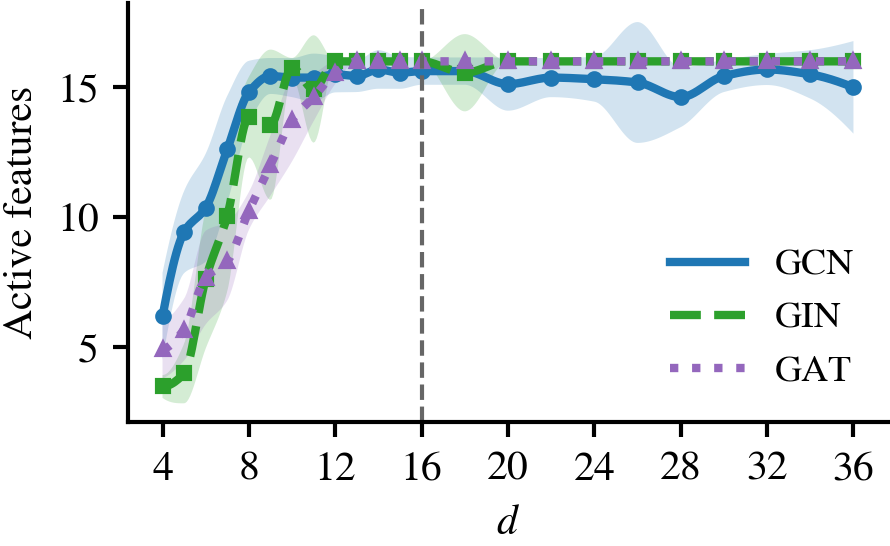

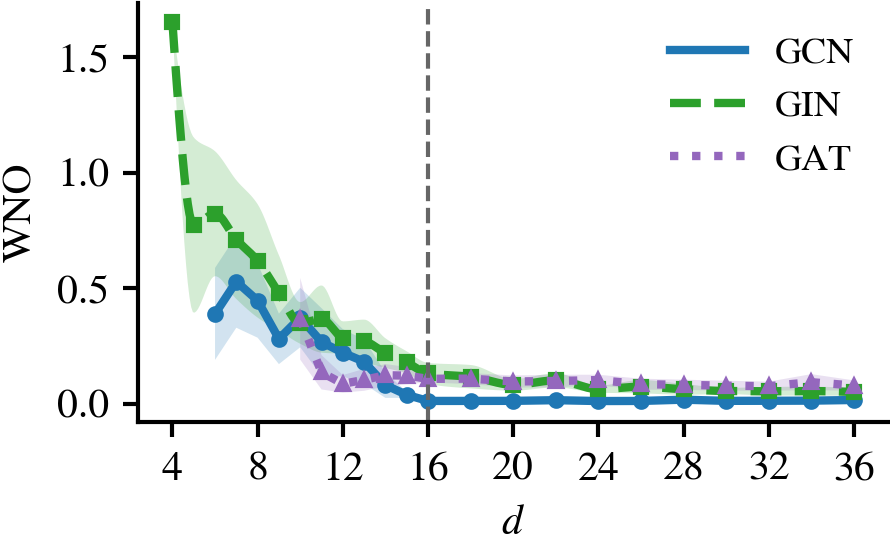

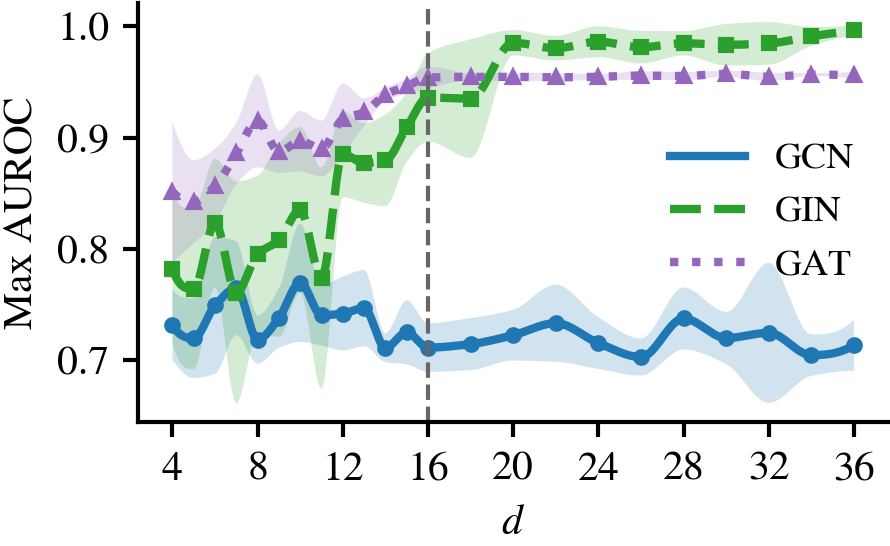

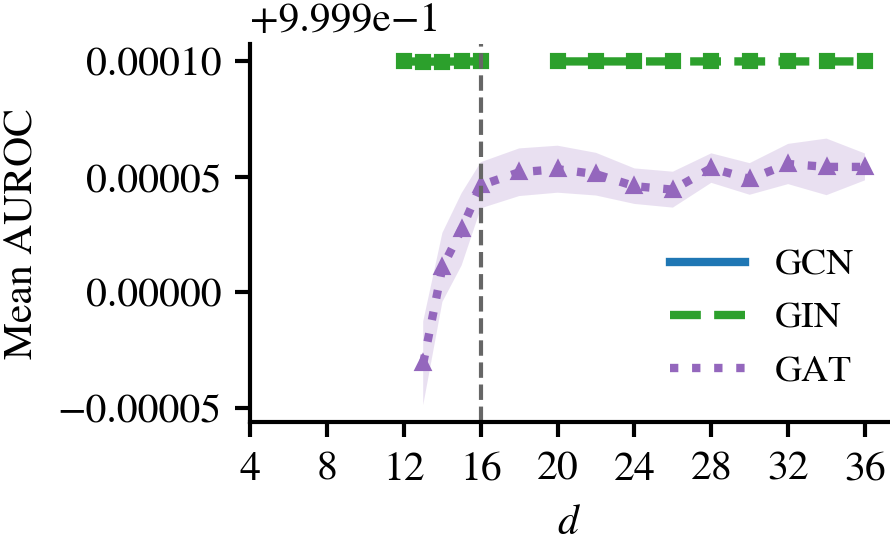

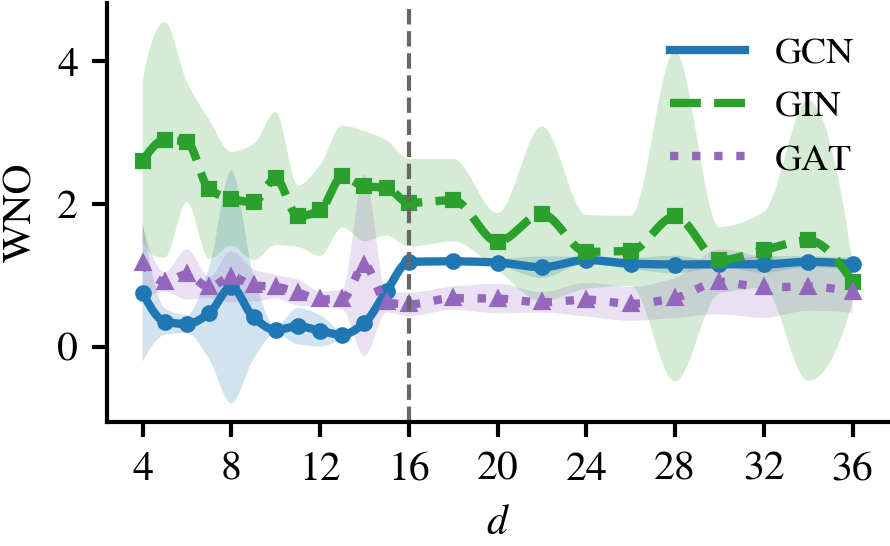

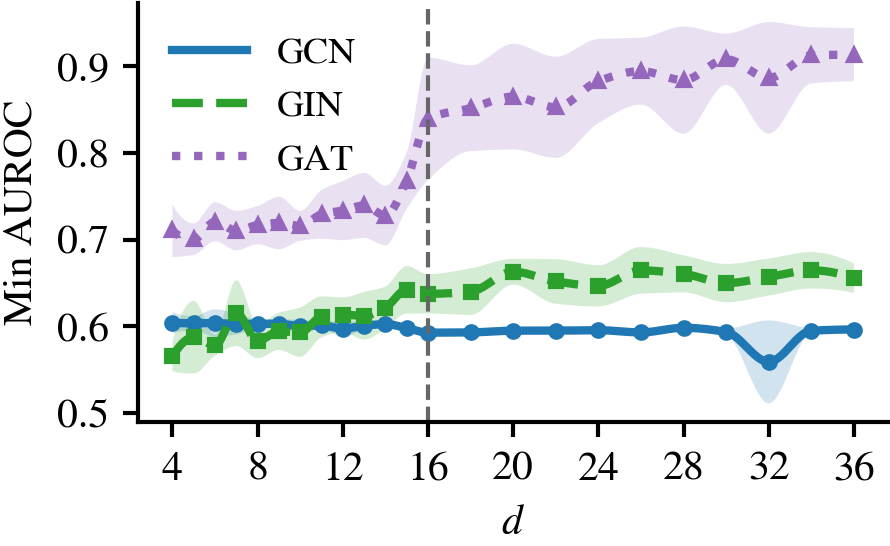

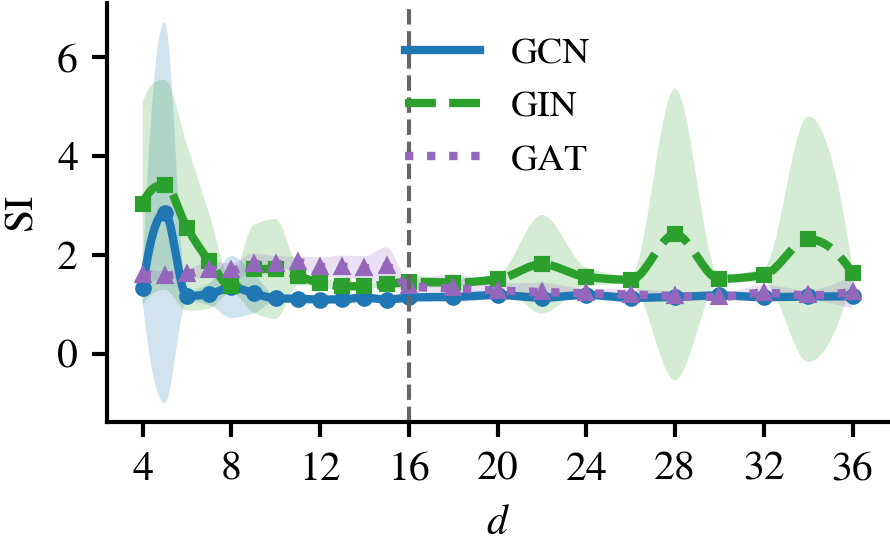

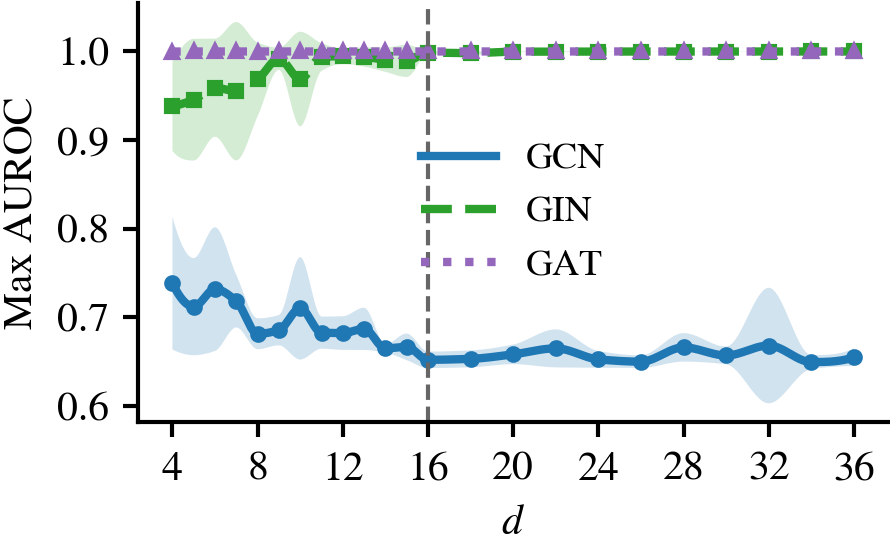

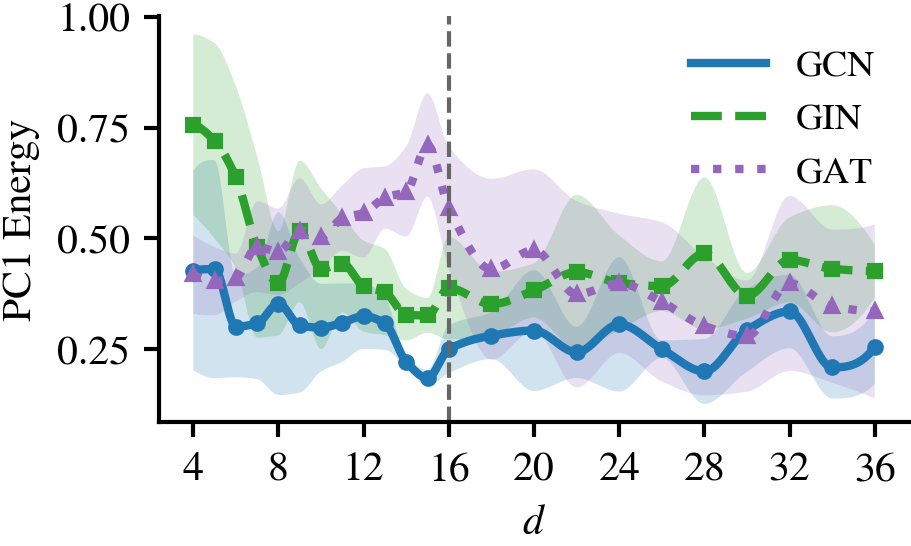

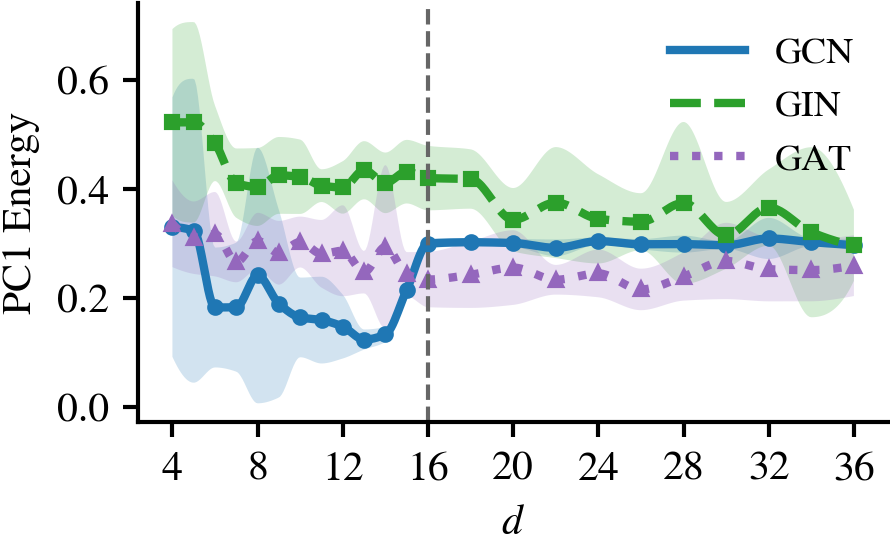

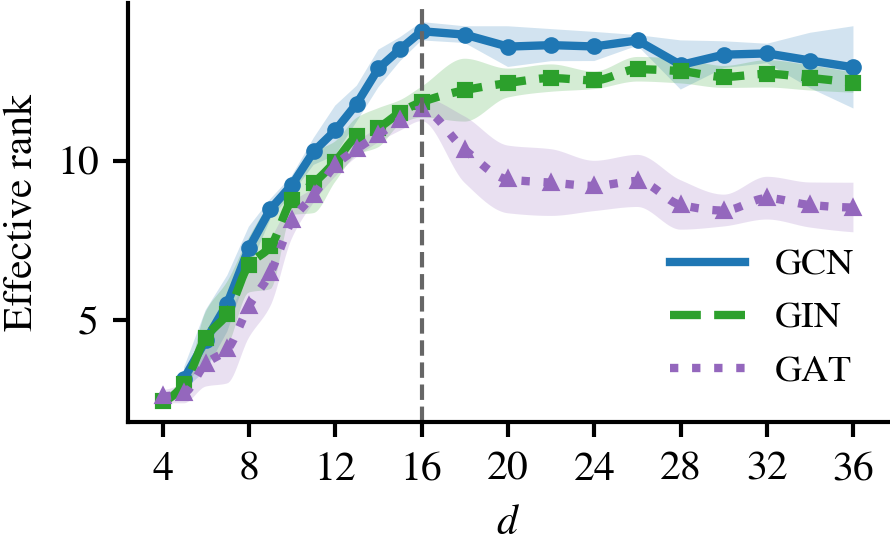

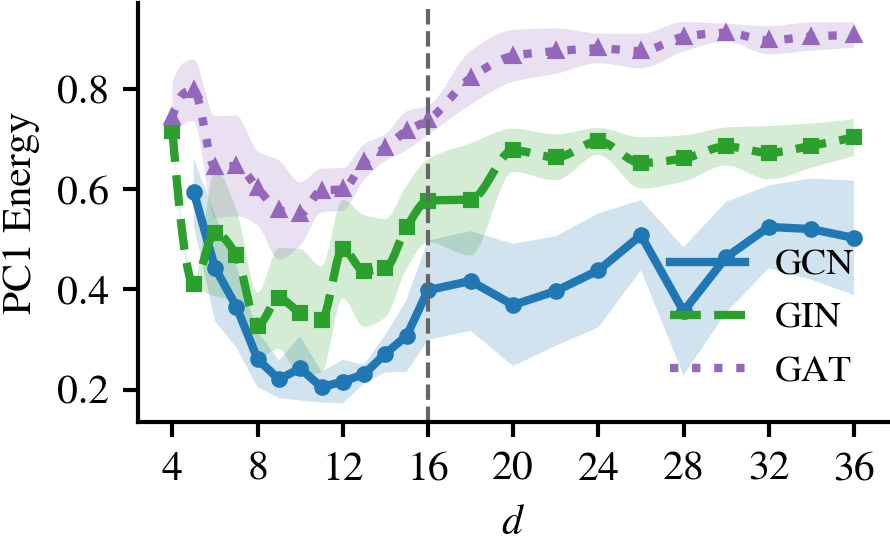

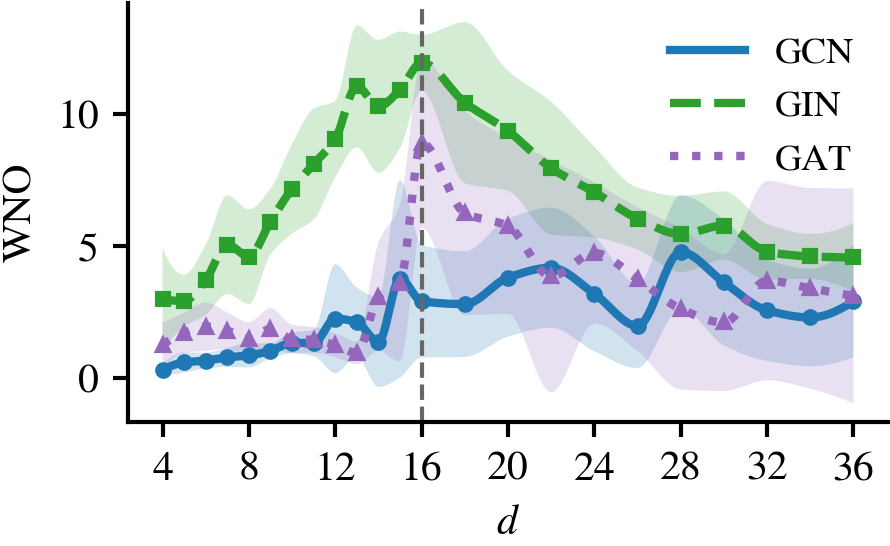

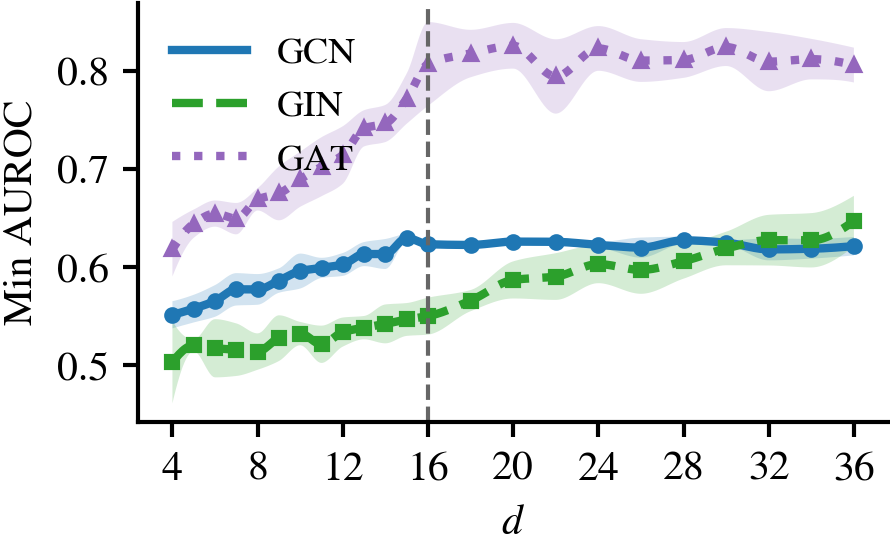

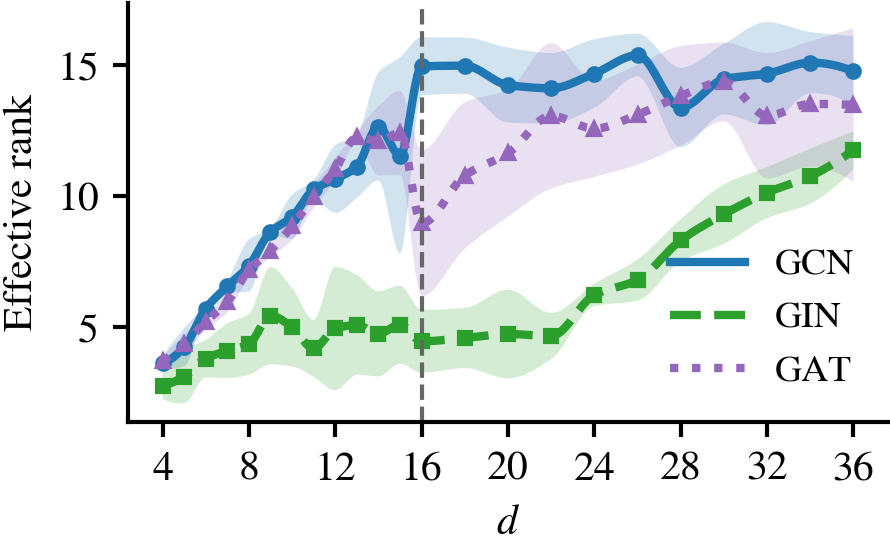

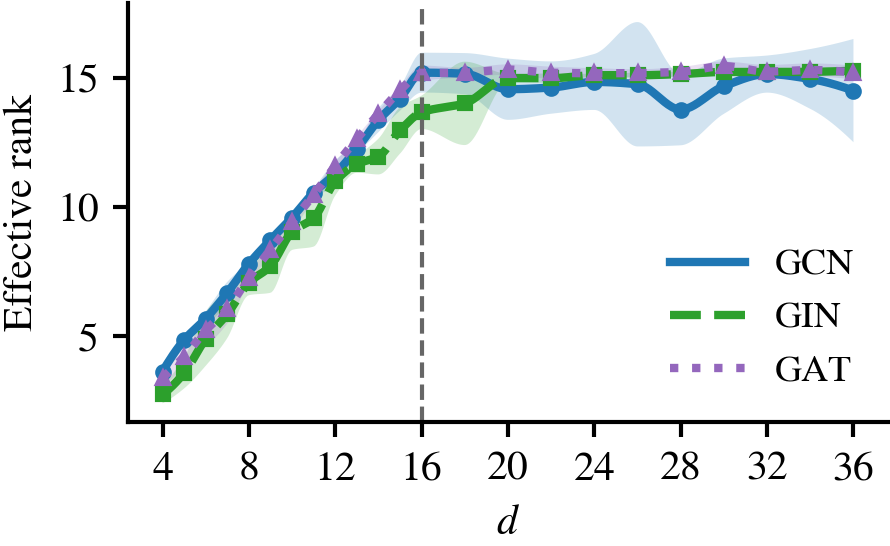

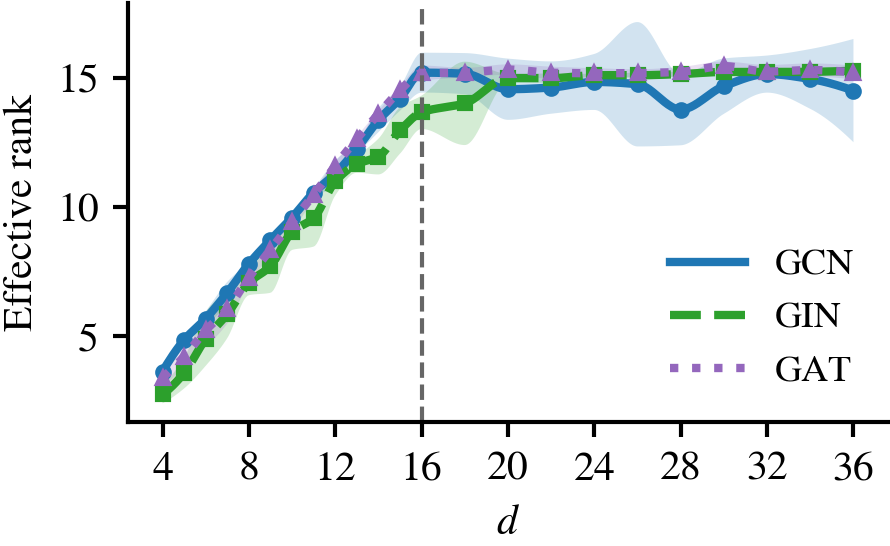

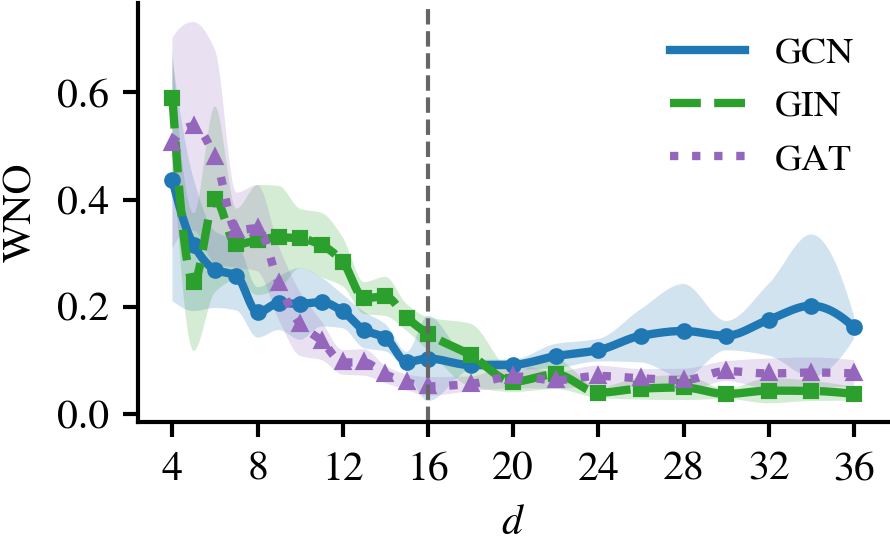

In [32]:
translator = {
    'acc': "Test Accuracy",
    'loss': "Test Loss",
    'active_count': "Active features",
    'si': "SI",
    'WNO_i': "WNO",
    'er': "Effective rank",
    'auc_mean': "Mean AUROC",
    'auc_min': "Min AUROC",
    'auc_max': "Max AUROC",
    'auc_diff': "Diff AUROC",
    'pc1': "PC1 Energy"
}

all_labels = set()
for agg1 in results_per_model.values():
    for agg2 in agg1.values():
        all_labels.update(agg2.keys())

for metric in all_labels:
    name = next((v for k, v in translator.items() if k in metric), metric)
    if name == metric:
        continue

    plot_overlayed_ribbons(results_per_model, metric, name, n=5, smooth=True)
    os.makedirs("figures/overlay", exist_ok=True)
    plt.savefig(f'figures/overlay/{metric}.pdf')


In [25]:
translator = {
    'acc': "Test Accuracy",
    'loss': "Test Loss",
    'active_count': "Active features",
    'si': "SI",
    'WNO_i': "WNO",
}
for metric in all_labels:
    name = metric
    for k, v in translator.items():
        if k in metric:
            name = v
    if name == metric:
        continue

    y_range = None
    if model_type == "GCN" and metric == "feature_geometry_node_concept_12_WNO_i":
        y_range = [0, 5]

    plot_graph_ribbon(to_aggregate, metric, name, n=5, smooth=True, y_range=y_range)
    dir_path = f"figures/{model_type}"
    os.makedirs(dir_path, exist_ok=True)
    plt.savefig(f'{dir_path}/{metric}.pdf')

NameError: name 'plot_graph_ribbon' is not defined

In [7]:
plot_graph_ribbon(to_aggregate, "active_count", "Active features", n=5, smooth=True)
plt.savefig('figures2/plot_d_vs_active.pdf')


IndexError: list index out of range

/tmp/ipykernel_524639/2116665631.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


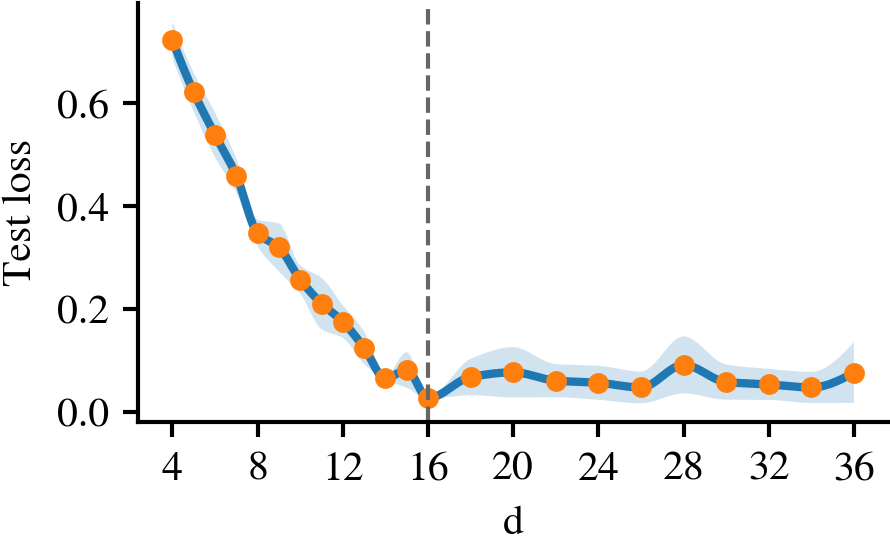

In [135]:
plot_graph_ribbon(to_aggregate, "loss", "Test loss", n=5, smooth=True)
plt.savefig('figures2/d_vs_loss.pdf')

/tmp/ipykernel_524639/2116665631.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


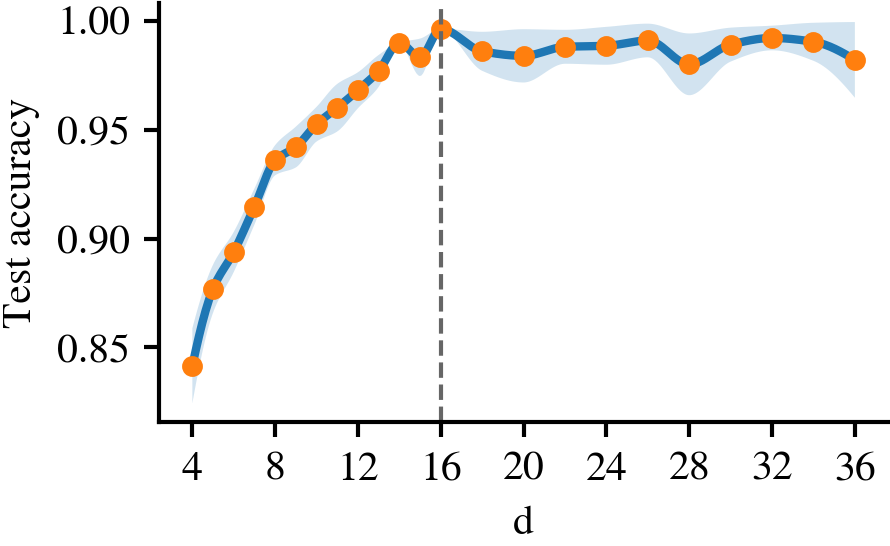

In [136]:
plot_graph_ribbon(to_aggregate, "acc", "Test accuracy", n=5, smooth=True)
plt.savefig('figures2/d_vs_acc.pdf')

/tmp/ipykernel_524639/2116665631.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


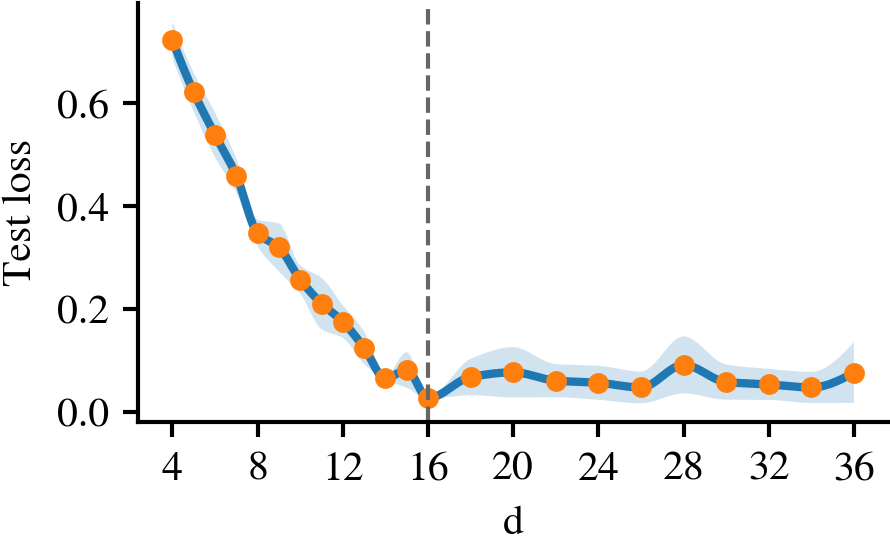

In [137]:
plot_graph_ribbon(to_aggregate, "loss", "Test loss", n=5, smooth=True)
plt.savefig('figures2/d_vs_loss.pdf')

/tmp/ipykernel_524639/2116665631.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


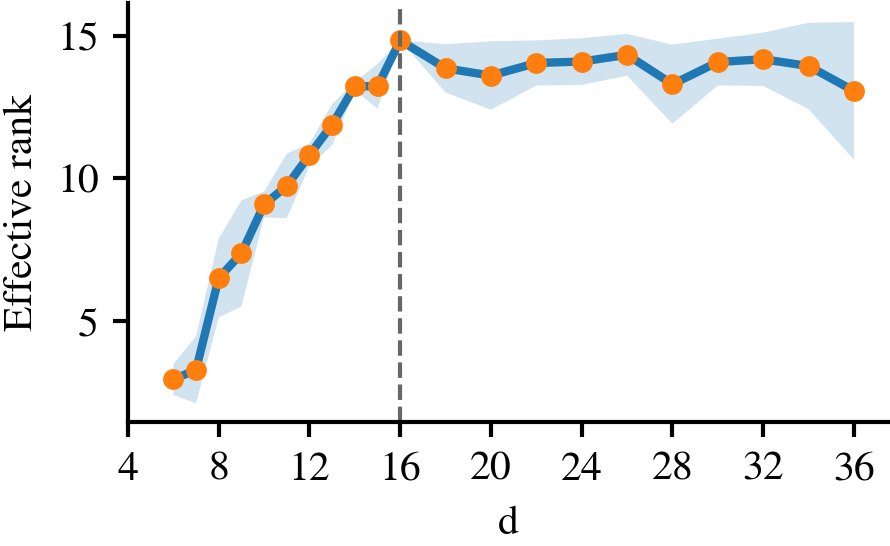

In [138]:
plot_graph_ribbon(to_aggregate, "er", "Effective rank", n=5, smooth=True)
plt.savefig('figures2/plot_d_vs_eff_raw.pdf')


/tmp/ipykernel_524639/2116665631.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


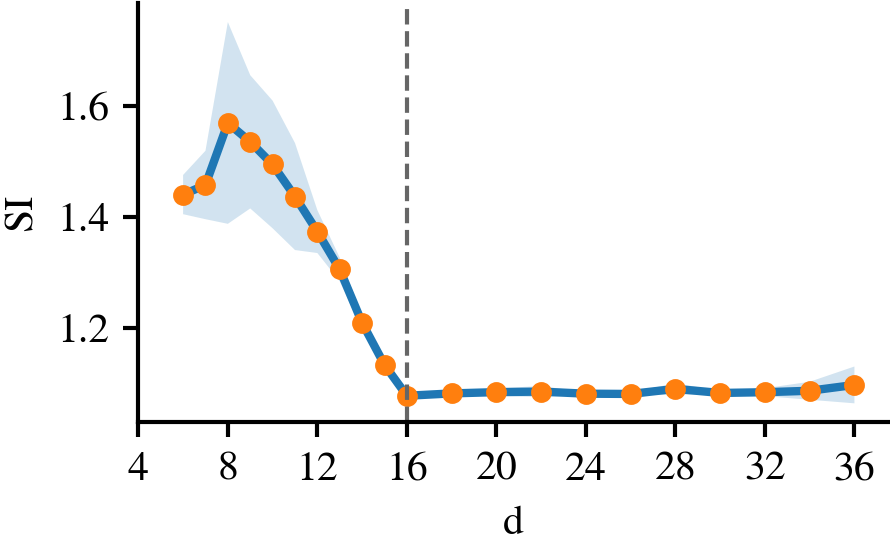

In [139]:
plot_graph_ribbon(to_aggregate, "si", "SI", n=5, smooth=True)
plt.savefig('figures2/plot_d_vs_si.pdf')


/tmp/ipykernel_524639/2116665631.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


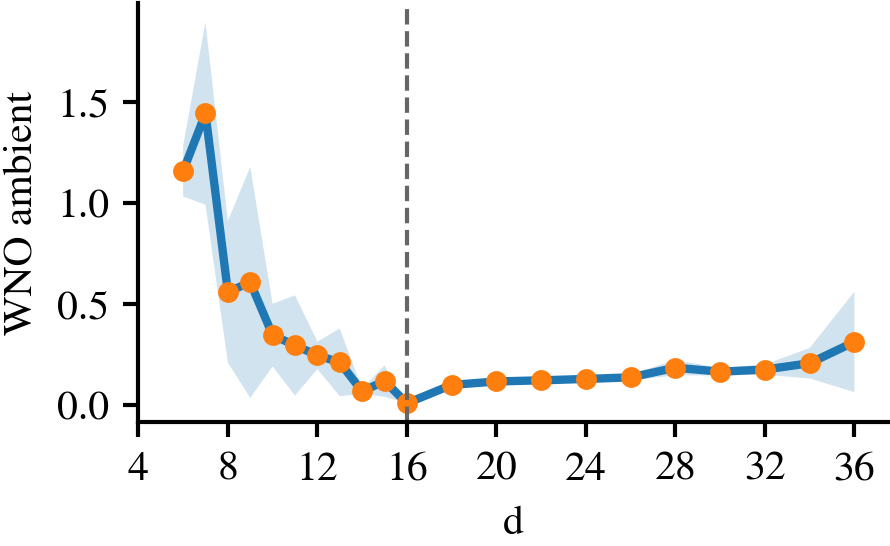

In [140]:
plot_graph_ribbon(to_aggregate, "WNO_a", "WNO ambient", n=5, smooth=True)
plt.savefig('figures2/plot_d_vs_WNO_a.pdf')

/tmp/ipykernel_524639/2116665631.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


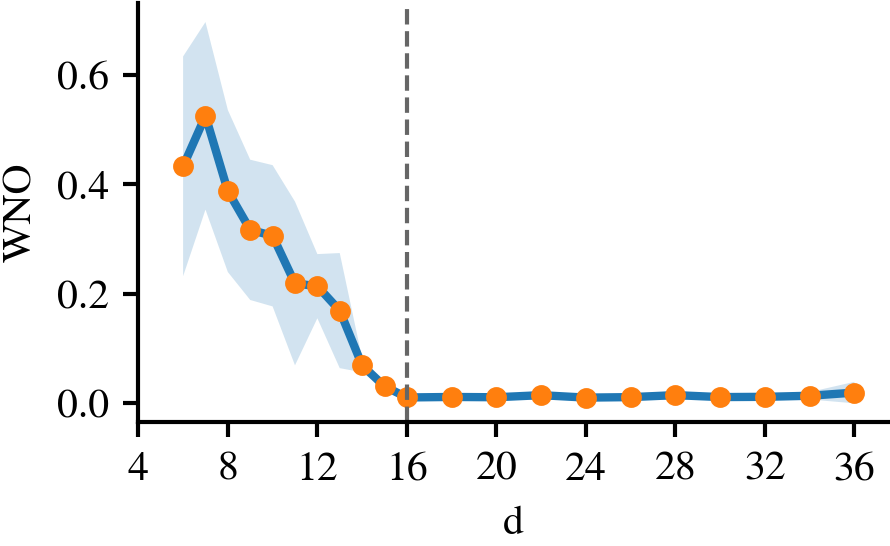

In [141]:
plot_graph_ribbon(to_aggregate, "WNO_i", "WNO", n=5, smooth=True)
plt.savefig('figures2/plot_d_vs_WNO.pdf')